# Structuring Sequences - POC

### Resume
1. en/ru POC corpora - tokenization is self-optimized by ~S and mean and production of ~S and C% 
    1. en - perfectly (1.0)
    2. ru - good (0.77-1.0)
2. en/ru POC corpora - morhpology - PROGRESS...


### Goal: Paper "Unsupervised text segmentation" (IJCAI?)
    - Multi-lingual
        - English
        - Russian
        - Chinese?
    - Multi-level
        - Morphology Parsing
            - morhemes - precision against dictionary of ones
            - morhemes - matching against categories of ones
            - symbol category - matching against symbol categories such as vowels, consonants, numbers, punctuations, etc. 
        - Tokenization & Lexicon Discovery
            - F1 against reference tokenization
            - precision against lexicon dictionary
        - Sentence/Phrase Segmentation
            - F1 against reference phrase/sentence segmentation
            - F1 for punctuation recovery against STT streams 
        - Grammar Learning
            - precision against idioms/phraseologisms dictionary
            - word categories - matching against reference POS/gender/number/tense/sense/etc. taxonomies/sub-taxonimies
            - grammar/sentence patterns (on categories) - matching against reference ones
            - predictiveness of the language model according to [Ben Goerzel](https://arxiv.org/pdf/2005.12533.pdf)
    - Modes
        - Batch
        - Incremental
        - Incremental with Curriculum
    - Corpora
        - POC
        - Basic (eg. English Brown)
        - Large (eg. News or Books)
        - Huge (eg. Common Crawl)

### Study in progress:
    - morphology
        - en/ru poc corpus
            - use model based on texts (FAILED)
            - use model based on words (TODO)
        - en/ru lexicon with counts, having text counts passed as optional parameter to train explicitly for a text
            - use model based on words (TODO)
        - en/ru lexicon w/o counts
        - en/ru large corpora
    - tokenization
        - better self-tune parameters on ~C and %S


In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


## Tokenization

### Get POC dataset 

In [2]:
texts = [
'мама мыла машу',
'маша мыла маму',
'маша ела кашу',
'мама ела кашу',
'маша ела суши',
'мама ела суши',
'мама мыла раму',
'маша мыла раму',
'мама мыла нишу',
'маша мыла нишу',
'мама мыла нашу машу',
'маша мыла нашу маму',
'мало мама мыла машу',
'мало маша мыла маму',
'мама мыла машу мылом',
'маша мыла маму мылом',
'маша ела мало каши',
'маша ела мало суши',
'мама ела мало суши',
'маша ела мало суши',
'мама мыла нашу машу мылом',
'маша мыла нашу маму мылом',
'мало мама мыла машу мылом',
'мало маша мыла маму мылом',
'мало мама мыла нашу машу мылом',
'мало маша мыла нашу маму мылом',
    
'соня идет тут',
'соня сидит тут',
'соня поет тут',
'сеня идет тут',
'сеня сидит тут',
'соня поет тут',
'тоня идет тут',
'тоня сидит тут',
'тоня поет тут',
    
'соня спит сидя',
'сеня спит сидя',
'тоня спит сидя',

'петр пил воду',
'петр пил сок',
'петр ел суп',
'петр видел сон',
'егор пил воду',
'егор пил сок',
'егор ел суп',
'егор видел сон',

'саня пил воду',
'саня пил сок',
'саня ел суп',
'саня видел сон',
'ваня пил воду',
'ваня пил сок',
'ваня ел су',
'ваня видел сон',

'рана болит',
'баба ворчит',
'рёв гремит',
'бог дан',
'дед едет',
'возле ёлки',
'всё же',
'ёж злит',
'обоз идет',
'делали йогу',
'надой коров',
'сок лимона',
'пол мыт',
'дом наш',
'дан обет',
'мало пива',
'суп радует',
'ветер силен',
'рис тверд',
'торт удался',
'ему фартило',
'шарф худой',
'запах цемента',
'конец эры',
'игры эти',
'сплю я здесь',
]

#абвгдеёжзийклмнопрстуфхцщъыьэюя

test_text = " ".join([texts[0],texts[-1]])

text_periods = ". ".join(texts)+"."
test_text_periods = ". ".join([texts[0],texts[-1]])+"."

print(text_periods)
print(test_text_periods)

мама мыла машу. маша мыла маму. маша ела кашу. мама ела кашу. маша ела суши. мама ела суши. мама мыла раму. маша мыла раму. мама мыла нишу. маша мыла нишу. мама мыла нашу машу. маша мыла нашу маму. мало мама мыла машу. мало маша мыла маму. мама мыла машу мылом. маша мыла маму мылом. маша ела мало каши. маша ела мало суши. мама ела мало суши. маша ела мало суши. мама мыла нашу машу мылом. маша мыла нашу маму мылом. мало мама мыла машу мылом. мало маша мыла маму мылом. мало мама мыла нашу машу мылом. мало маша мыла нашу маму мылом. соня идет тут. соня сидит тут. соня поет тут. сеня идет тут. сеня сидит тут. соня поет тут. тоня идет тут. тоня сидит тут. тоня поет тут. соня спит сидя. сеня спит сидя. тоня спит сидя. петр пил воду. петр пил сок. петр ел суп. петр видел сон. егор пил воду. егор пил сок. егор ел суп. егор видел сон. саня пил воду. саня пил сок. саня ел суп. саня видел сон. ваня пил воду. ваня пил сок. ваня ел су. ваня видел сон. рана болит. баба ворчит. рёв гремит. бог дан. д

### Evaluate 1-st order structures with NO periods

3706


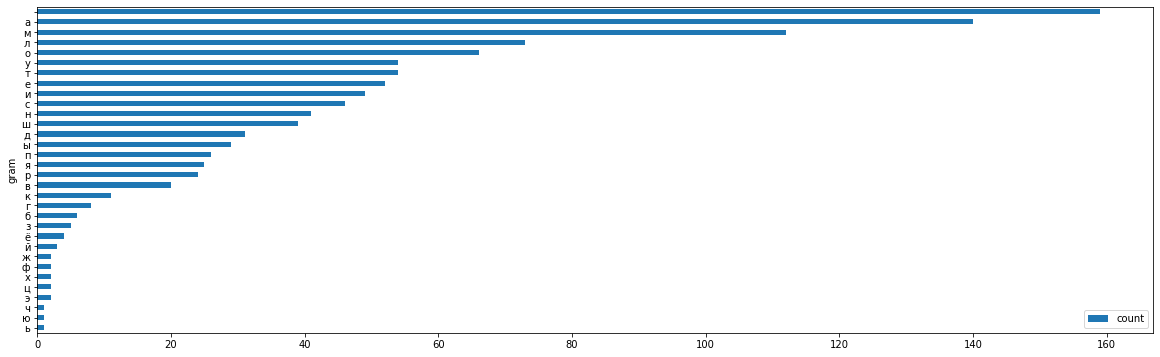

In [3]:
mini_ru_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_ru_base.train(texts)
print(mini_ru_base.count_params())
dic = dict([(key,mini_ru_base.model[0][key]) for key in mini_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')

3706


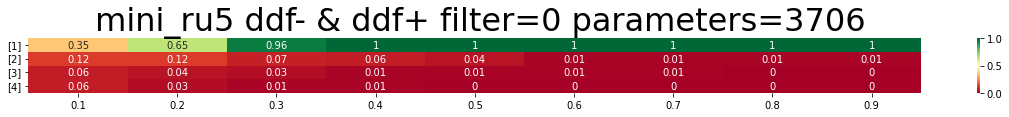

In [4]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2],[3],[4]]#,[5]]

print(mini_ru_base.count_params())
title = ' mini_ru5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_ru_base.model,filter_threshold)
    parameters = mini_ru_base.count_params()
    evaluate_freedom_tokenizer_options(texts,ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters))


['мама', ' ', 'мыла', ' ', 'машу', ' ', 'сплю', ' ', 'я', ' ', 'здесь']
['мама', ' ', 'мыла', ' ', 'машу', ' ', 'сплю', ' ', 'я', ' ', 'здесь']


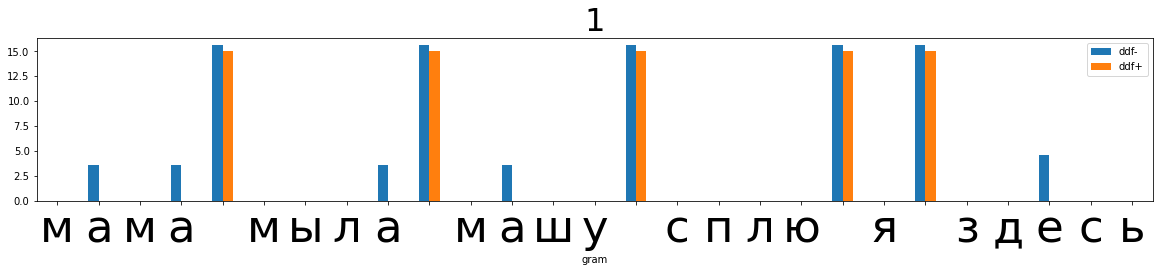

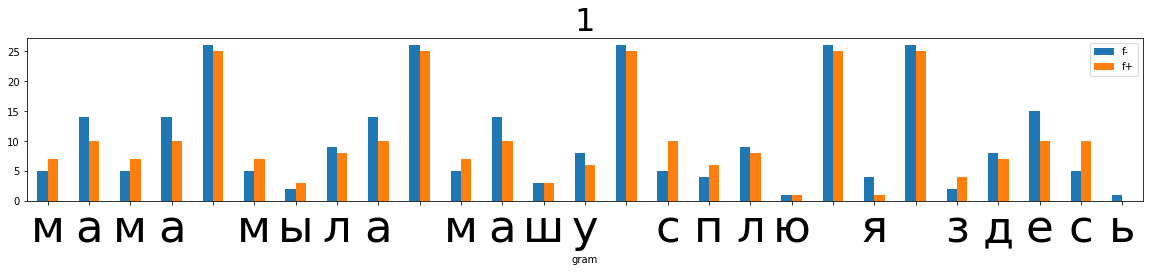

In [5]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
    tokenizer.set_options(nlist = [1], threshold=0.5) # 0.5
    t0 = ref_tokenizer.tokenize(test_text)
    t1 = tokenizer.tokenize(test_text)
    assert t0 == t1
    print(t0)
    print(t1)  
    df = profile_freedoms_ex_df(mini_ru_base.model,test_text,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


### Evaluate 1-st order structures WITH periods

5860


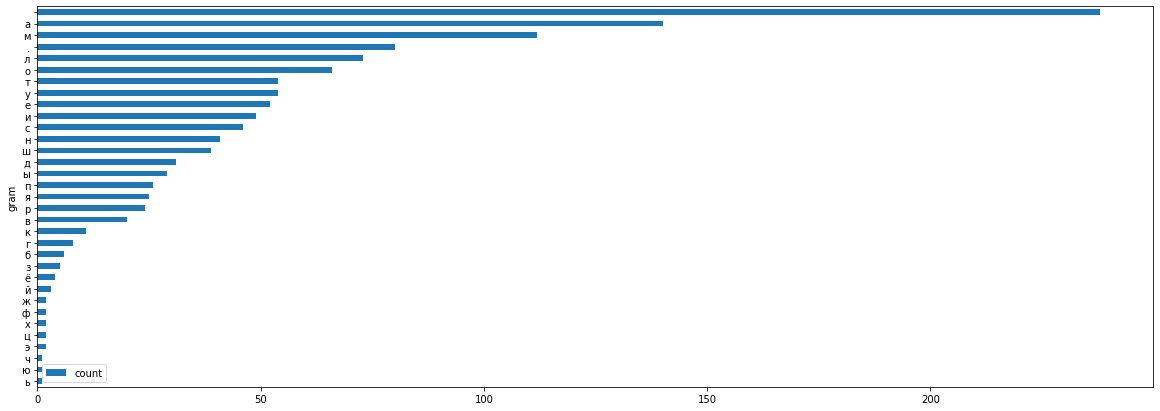

In [6]:
mini_ru_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_ru_base.train([text_periods])
print(mini_ru_base.count_params())
dic = dict([(key,mini_ru_base.model[0][key]) for key in mini_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')

5860


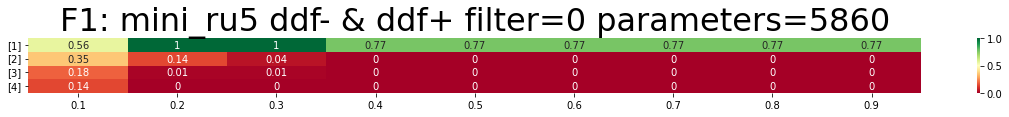

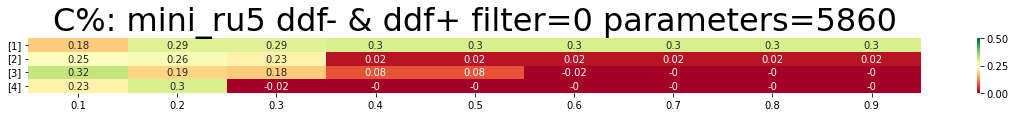

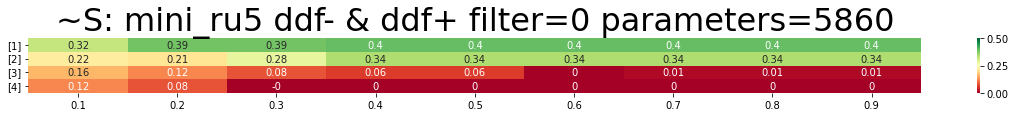

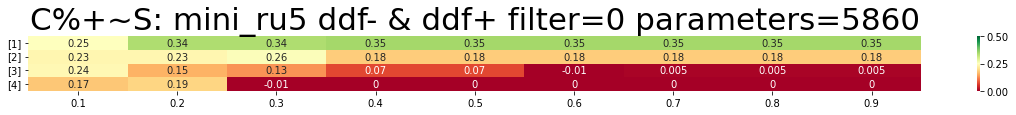

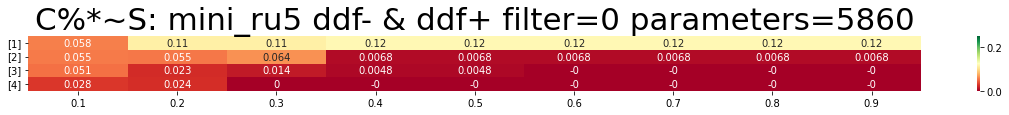

In [7]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2],[3],[4]]#,[5]]

print(mini_ru_base.count_params())
title = ' mini_ru5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_ru_base.model,filter_threshold)
    parameters = mini_ru_base.count_params()
    evaluate_freedom_tokenizer_multimetrics([text_periods],ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters),crossmetrics=True)


['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']
['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']


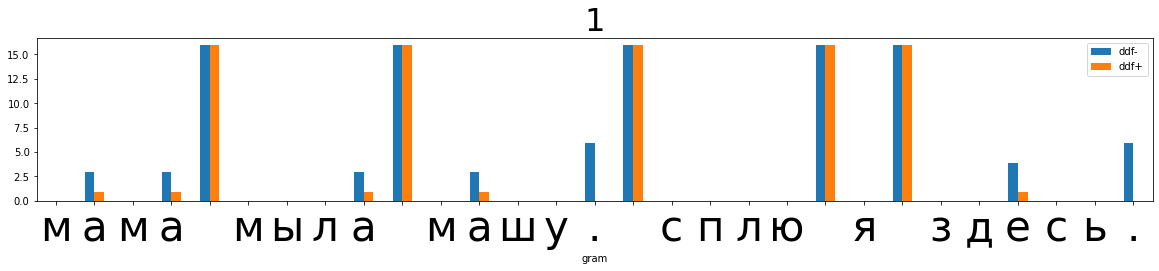

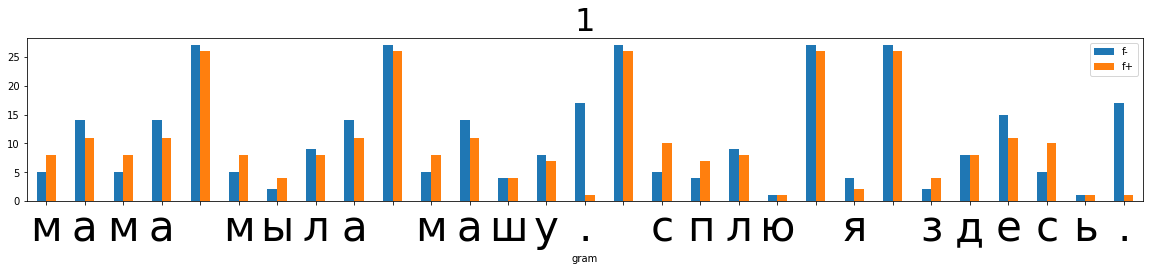

In [8]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
    tokenizer.set_options(nlist = [1], threshold=0.3)
    t0 = ref_tokenizer.tokenize(test_text_periods)
    t1 = tokenizer.tokenize(test_text_periods)
    assert t0 == t1
    print(t0)
    print(t1)  
    df = profile_freedoms_ex_df(mini_ru_base.model,test_text_periods,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


### Evaluate 1-st order structures WITH periods with reference (trained on large data set) model

In [9]:
rusage_test_chars_7a = FreedomTokenizer(name='data/models/rusage_test_chars_7a',max_n=7,mode='chars',debug=False)
print(rusage_test_chars_7a.count_params())


75193666


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


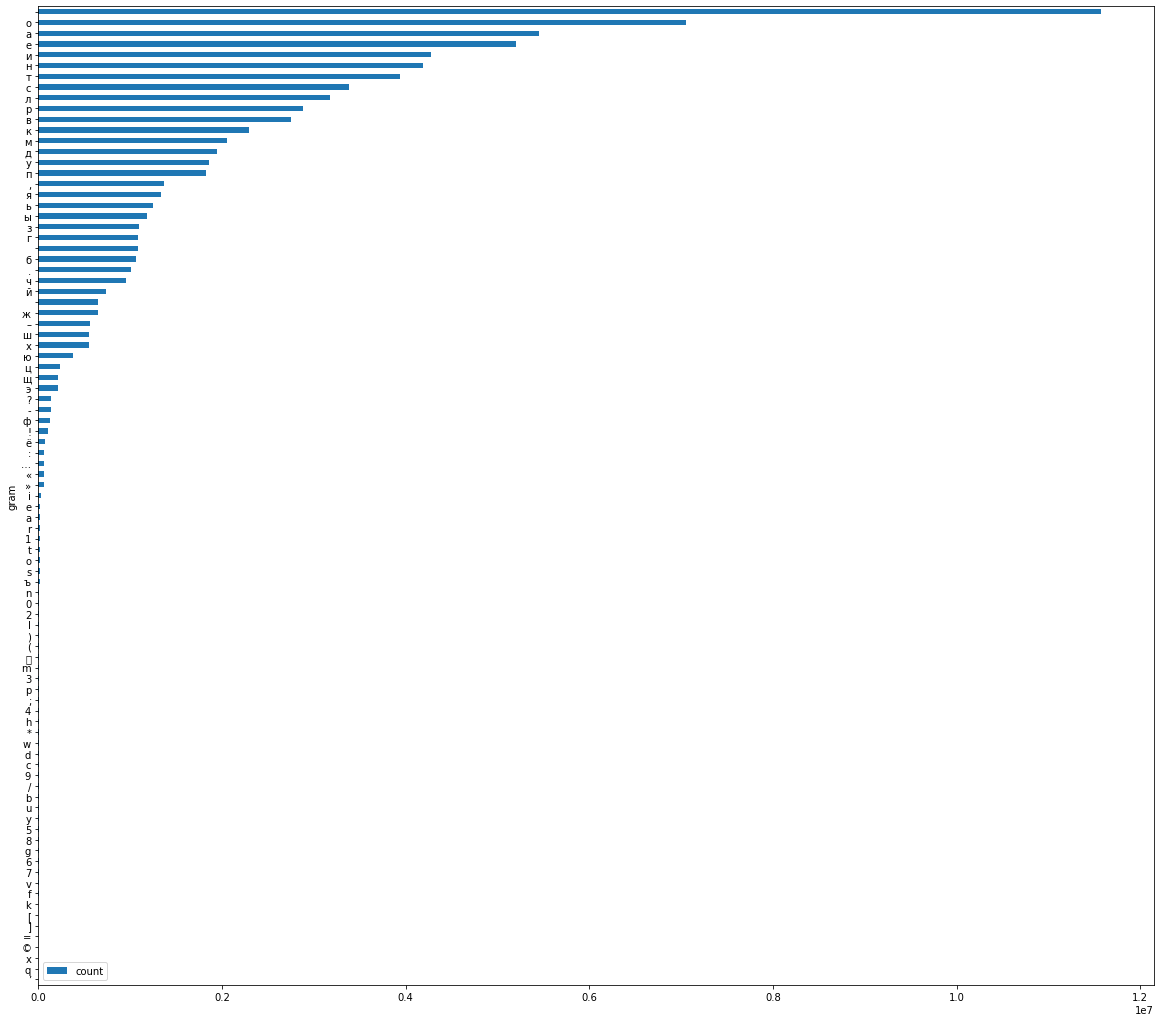

In [10]:
dic = dict([(key,rusage_test_chars_7a.model[0][key]) for key in rusage_test_chars_7a.model[0] if len(key) == 1 and rusage_test_chars_7a.model[0][key] >= 1000])
plot_dict(dic,'gram','count')


['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']
['мама', ' ', 'мыла', ' ', 'машу', '.', ' ', 'сплю', ' ', 'я', ' ', 'здесь', '.']


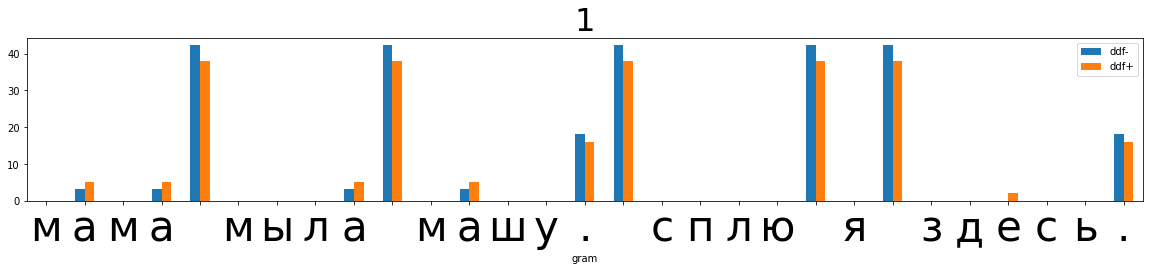

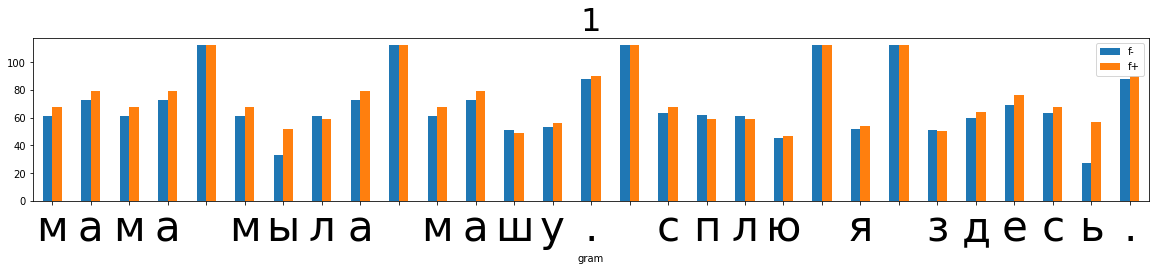

In [11]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(rusage_test_chars_7a,'ddf-','ddf+')
    tokenizer.set_options(nlist = [1], threshold=0.3)
    t0 = ref_tokenizer.tokenize(test_text_periods)
    t1 = tokenizer.tokenize(test_text_periods)
    assert t0 == t1
    print(t0)
    print(t1)
    df = profile_freedoms_ex_df(rusage_test_chars_7a.model,test_text_periods,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    #plot_bars(df,'gram',['peak-','peak+'],title=str(i))


### Evaluate 1-st order structures for Russian WITH periods from file

In [12]:
with open('./data/corpora/Russian/poc_ru.txt',errors='ignore') as f:
    lines = f.readlines()
lines = [line.strip() for line in lines]    
lines = [line for line in lines if len(line) > 0]
print(len(lines))
text_ru = " ".join(lines)
text_ru


80


'мама мыла машу. маша мыла маму. маша ела кашу. мама ела кашу. маша ела суши. мама ела суши. мама мыла раму. маша мыла раму. мама мыла нишу. маша мыла нишу. мама мыла нашу машу. маша мыла нашу маму. мало мама мыла машу. мало маша мыла маму. мама мыла машу мылом. маша мыла маму мылом. маша ела мало каши. маша ела мало суши. мама ела мало суши. маша ела мало суши. мама мыла нашу машу мылом. маша мыла нашу маму мылом. мало мама мыла машу мылом. мало маша мыла маму мылом. мало мама мыла нашу машу мылом. мало маша мыла нашу маму мылом. соня идет тут. соня сидит тут. соня поет тут. сеня идет тут. сеня сидит тут. сеня поет тут. тоня идет тут. тоня сидит тут. тоня поет тут. соня спит сидя. сеня спит сидя. тоня спит сидя. петр пил воду. петр пил сок. петр ел суп. петр видел сон. егор пил воду. егор пил сок. егор ел суп. егор видел сон. саня пил воду. саня пил сок. саня ел суп. саня видел сон. ваня пил воду. ваня пил сок. ваня ел суп. ваня видел сон. рана болит. баба ворчит. рёв гремит. бог дан.

5856


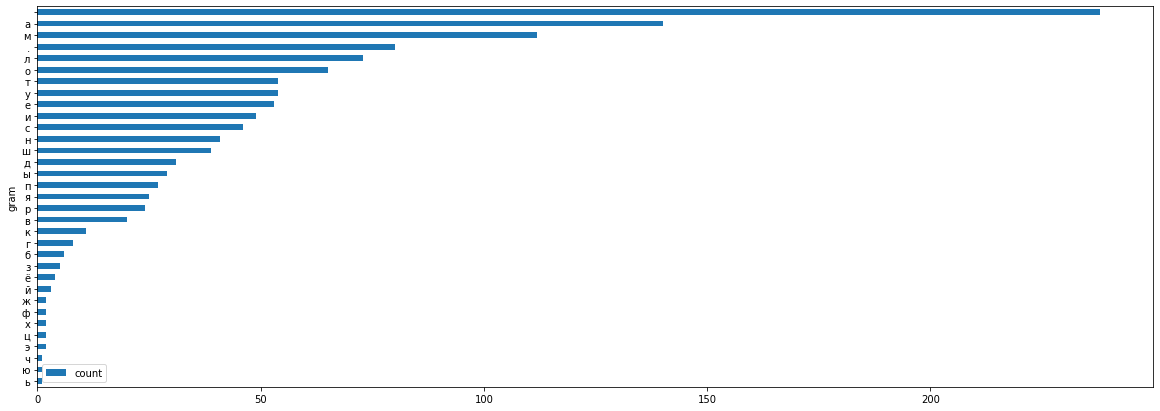

In [13]:
mini_ru_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_ru_base.train([text_ru])
print(mini_ru_base.count_params())
dic = dict([(key,mini_ru_base.model[0][key]) for key in mini_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


5856


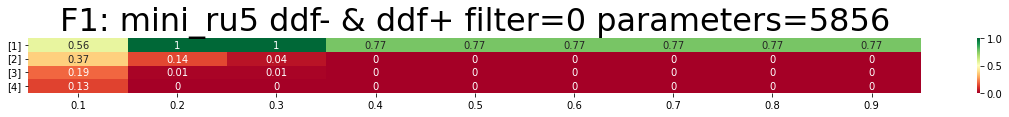

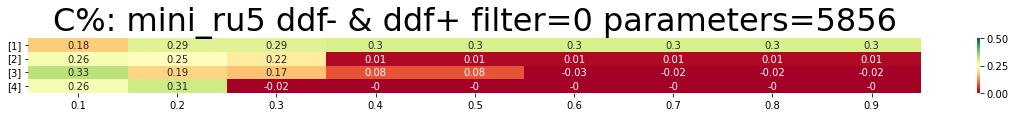

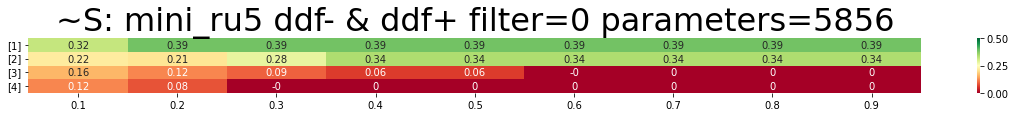

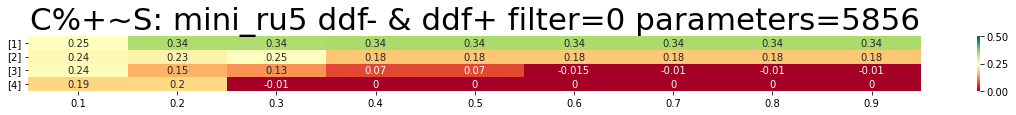

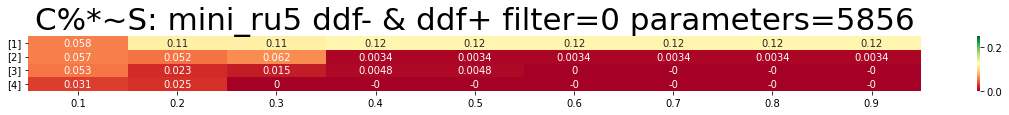

In [14]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2],[3],[4]]#,[5]]

print(mini_ru_base.count_params())
title = ' mini_ru5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_ru_base.model,filter_threshold)
    parameters = mini_ru_base.count_params()
    evaluate_freedom_tokenizer_multimetrics([text_ru],ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters),crossmetrics=True)


### Evaluate 1-st order structures for English WITH periods from file

In [15]:
def load_corpus_multiline(fname):
    with open('./data/corpora/English/poc_en.txt',errors='ignore') as f:
        lines = f.readlines()
    lines = [line.strip().lower() for line in lines]    
    lines = [line for line in lines if len(line) > 0 and not line.startswith('#')]
    return lines

    print(len(lines))
    text_en = " ".join(lines)

lines = load_corpus_multiline('./data/corpora/English/poc_en.txt')

test_text_en = " ".join([lines[0],lines[-1]])

text_en = " ".join(lines)
text_en


'mom washed masha. masha washed mother. masha ate porridge. mother ate porridge. masha ate sushi. mom ate sushi. mother washed the frame. masha washed the frame. mother washed the niche. masha washed the niche. mom washed our masha. masha washed our mother. lother washed masha a bit. masha washed mother a bit. mom washed masha with soap. masha washed mother with soap. masha ate a bit of porridge. masha ate a bit of sushi. mom ate a bit of sushi. masha ate a bit of sushi. mom washed our masha with soap. masha washed our mother with soap. mother washed masha with soap a bit. masha washed mother with soap a bit. mother washed our masha with soap a bit. masha washed our mother with soap a bit. sonya is going here. sonya is sitting here. sonya is singing here. senya is going here. senya is sitting here. senya is singing here. tonya is going here. tonya is sitting here. tonya is singing here. sonya sleeps sitting. senya sleeps sitting. tonya sleeps sitting. peter drank water. peter drank jui

5856


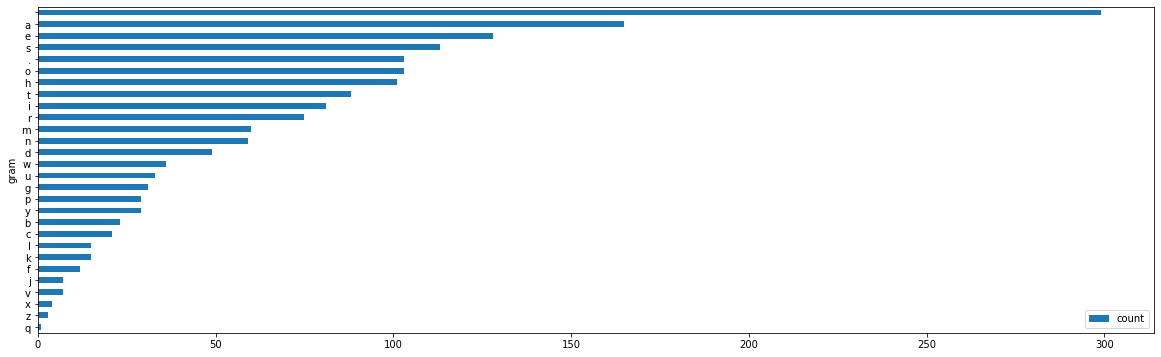

In [16]:
mini_en_base = FreedomTokenizer(max_n=5,mode='chars',debug=False)
mini_en_base.train([text_en])
print(mini_ru_base.count_params())
dic = dict([(key,mini_en_base.model[0][key]) for key in mini_en_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


7856


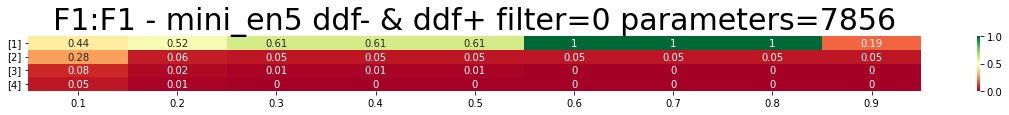

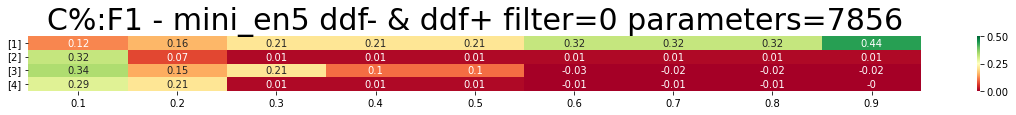

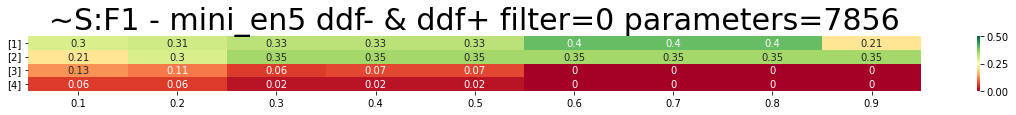

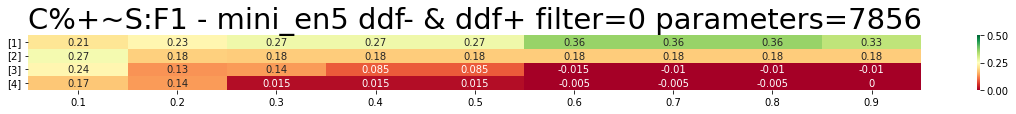

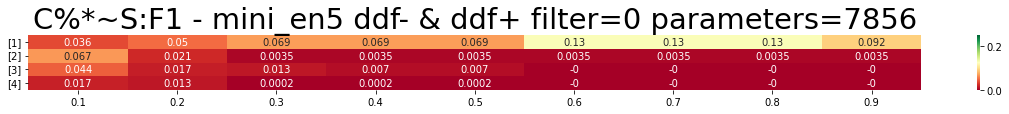

In [17]:
ref_tokenizer = DelimiterTokenizer()
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ngram_params = [[1],[2],[3],[4]]#,[5]]

print(mini_en_base.count_params())
title = 'F1 - mini_en5 ddf- & ddf+'
for filter_threshold in [0]:#,0.0001,0.001,0.01,0.1]:
    if filter_threshold > 0:
        model_compress_with_loss(mini_en_base.model,filter_threshold)
    parameters = mini_en_base.count_params()
    evaluate_freedom_tokenizer_multimetrics([text_en],ref_tokenizer,FreedomBasedTokenizer(mini_en_base,'ddf-','ddf+'),
        ngram_params,thresholds,title="{} filter={} parameters={}".format(title,filter_threshold,parameters),crossmetrics=True)


In [18]:
#print(mini_en_base.model[1][' '])
print(mini_en_base.model[2][' '])
#print(mini_en_base.model[1]['.'])
print(mini_en_base.model[2]['.'])
#print(mini_en_base.model[2]['o'])
print(mini_en_base.model[2]['o'])


{'m': 7, 'd': 23, '.': 102, 'a': 54, 'e': 19, 'r': 26, 'h': 9, 't': 5, 'f': 5, 'p': 5, 's': 13, 'g': 10, 'k': 10, 'b': 1, 'i': 1, 'l': 1, 'n': 1, 'o': 1, 'u': 1, 'v': 2, 'w': 1, 'x': 1, 'y': 1}
{'a': 3, 'r': 8, 'e': 22, 'i': 6, 't': 10, 'p': 10, 'g': 5, 'm': 6, 'h': 2, 'd': 6, 'x': 2, 'y': 3, 's': 3, 'n': 2, 'b': 2, 'c': 3, 'k': 2, 'o': 2, 'f': 1, 'j': 1, 'l': 1, 'u': 1, 'w': 1, 'z': 1}
{'m': 20, 'p': 3, ' ': 11, 'l': 1, 's': 18, 'g': 8, 't': 5, 'b': 2, 'c': 4, 'o': 8, 'j': 1, 'n': 5, 'w': 3, 'r': 4, 'y': 2, 'v': 1, 'h': 3, 'z': 1, 'f': 2, 'd': 1}


['mom', ' ', 'washed', ' ', 'masha', '.', ' ', 'buzz', '.']
['mom', ' ', 'washed', ' ', 'masha', '.', ' ', 'buzz', '.']


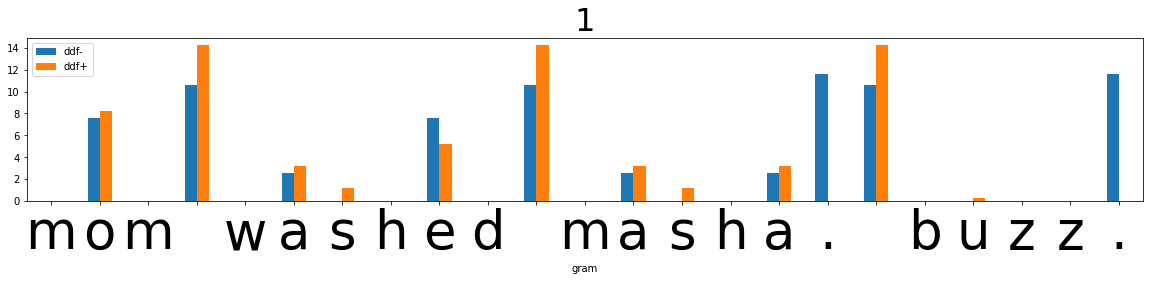

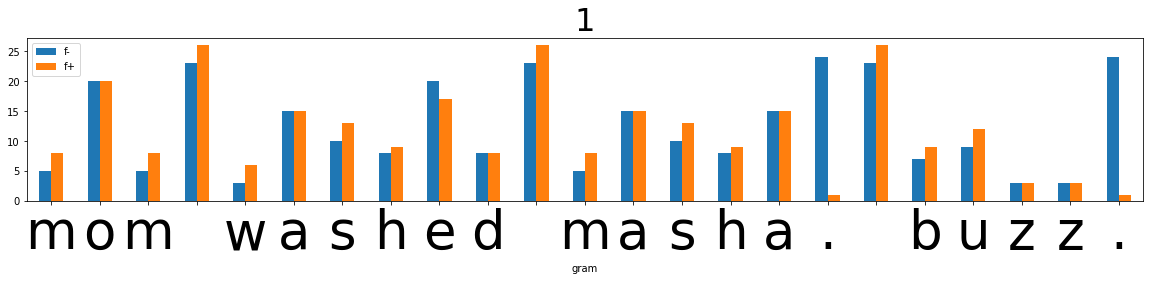

In [19]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(mini_en_base,'ddf-','ddf+')
    tokenizer.set_options(nlist = [1], threshold=0.7)
    t0 = ref_tokenizer.tokenize(test_text_en)
    t1 = tokenizer.tokenize(test_text_en)
    #assert t0 == t1
    print(t0)
    print(t1)
    df = profile_freedoms_ex_df(mini_en_base.model,test_text_en,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))


In [20]:
#TODO check English large vocabulary
brown_nolines_chars_7a = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
print(brown_nolines_chars_7a.count_params())


10967135


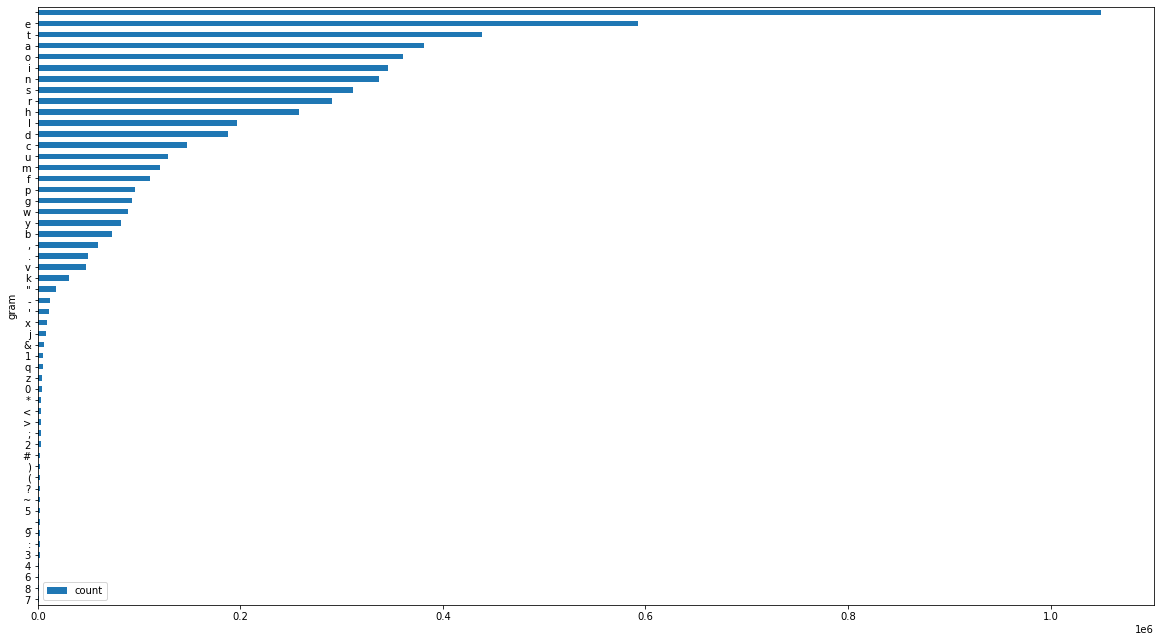

In [21]:
dic = dict([(key,brown_nolines_chars_7a.model[0][key]) for key in brown_nolines_chars_7a.model[0] if len(key) == 1 and brown_nolines_chars_7a.model[0][key] >= 1000])
plot_dict(dic,'gram','count')


['mom', ' ', 'washed', ' ', 'masha', '.', ' ', 'buzz', '.']
['mom', ' ', 'washed', ' ', 'masha', '.', ' ', 'buzz', '.']


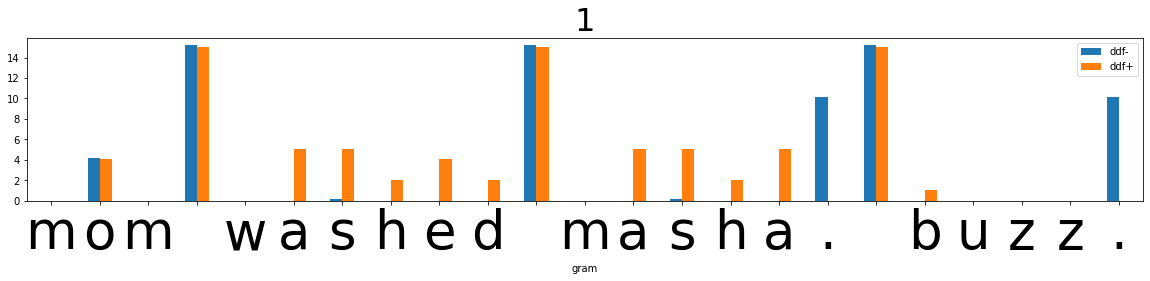

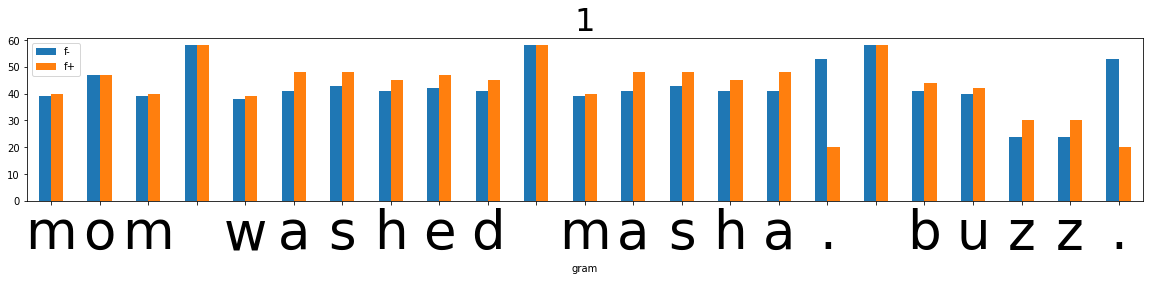

In [22]:
for i in range(1,1+1):
    tokenizer = FreedomBasedTokenizer(brown_nolines_chars_7a,'ddf-','ddf+')
    tokenizer.set_options(nlist = [1], threshold=0.5)
    t0 = ref_tokenizer.tokenize(test_text_en)
    t1 = tokenizer.tokenize(test_text_en)
    #assert t0 == t1
    print(t0)
    print(t1)
    df = profile_freedoms_ex_df(brown_nolines_chars_7a.model,test_text_en,i)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    plot_bars(df,'gram',['f-','f+'],title=str(i))


In [23]:
print(brown_nolines_chars_7a.model[2][' '])
print(brown_nolines_chars_7a.model[2]['.'])
print(brown_nolines_chars_7a.model[2]['o'])


{'e': 184081, 'n': 77196, 'y': 49368, 'd': 93989, 'f': 41710, 's': 105873, 't': 83231, 'o': 40262, '"': 1767, 'k': 7208, '.': 48454, ' ': 34502, 'r': 50027, ',': 57900, 'h': 24074, 'l': 27844, 'm': 13394, 'a': 26736, 'g': 27224, 'w': 7714, '#': 1281, '&': 4293, '1': 452, 'c': 4360, ':': 1538, '_': 962, 'x': 1038, '4': 316, '7': 213, '3': 285, '2': 418, 'p': 4868, '8': 265, '-': 3429, 'b': 690, '0': 1519, ')': 1377, 'i': 5687, '9': 167, 'u': 3205, "'": 717, '6': 250, '}': 239, 'z': 190, '5': 473, '+': 140, '?': 2231, ']': 84, ';': 2747, 'v': 191, '!': 722, '@': 281, '%': 121, '>': 2084, '`': 33, '/': 6, 'q': 7, 'j': 9}
{'e': 6829, 'd': 4648, '&': 194, '"': 3374, 'm': 1538, 'y': 3493, 's': 8425, 'n': 3722, 't': 4153, '3': 160, '1': 238, 'r': 2788, '7': 91, '2': 213, 'k': 759, '5': 129, 'h': 1079, 'l': 1363, 'f': 581, 'o': 572, 'g': 1512, 'a': 553, '4': 144, '6': 93, 'u': 93, 'w': 431, 'b': 96, '0': 267, 'x': 74, '8': 74, 'c': 212, '}': 42, '9': 94, ')': 371, ' ': 80, 'z': 23, 'p': 503, '

## Morphology

### Russian

In [24]:
tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
tokenizer.set_options(nlist = [1], threshold=0.3)
tokens_ru = tokenizer.tokenize(text_ru)


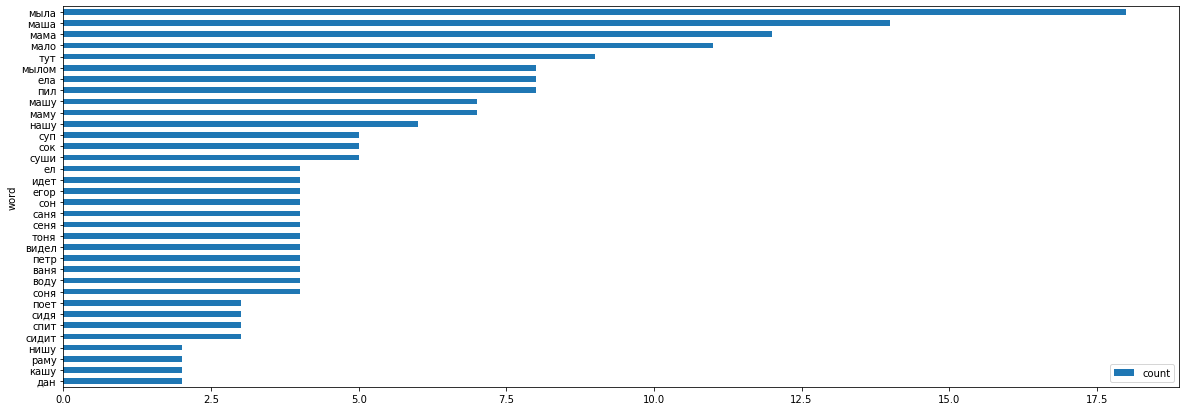

In [25]:
word_cnt_ru = {}
for t in tokens_ru:
    dictcount(word_cnt_ru,t)

dic = dict([(key,word_cnt_ru[key]) for key in word_cnt_ru if len(key) > 1 and word_cnt_ru[key] > 1])
plot_dict(dic,'word','count')
    

/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


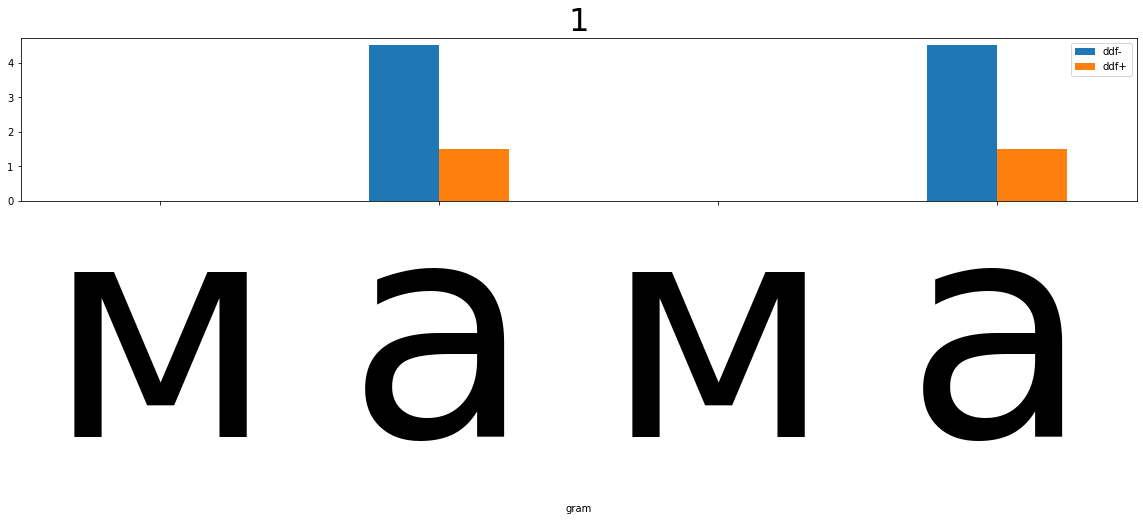

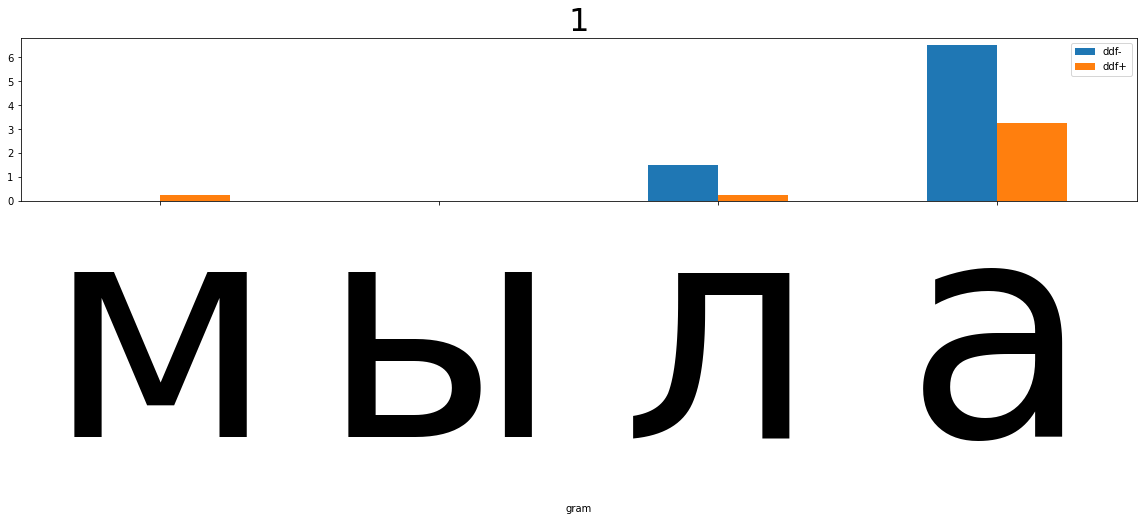

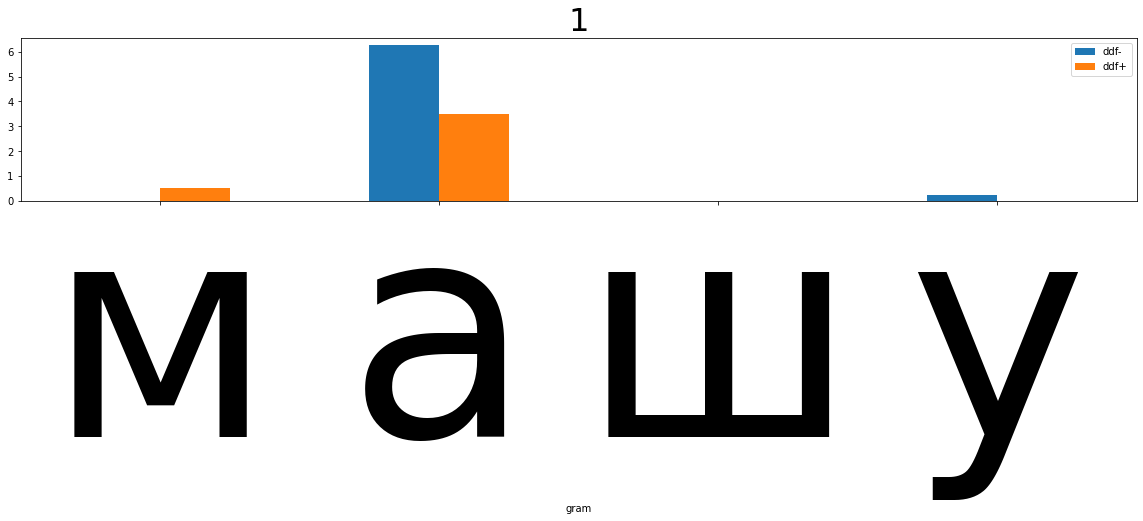

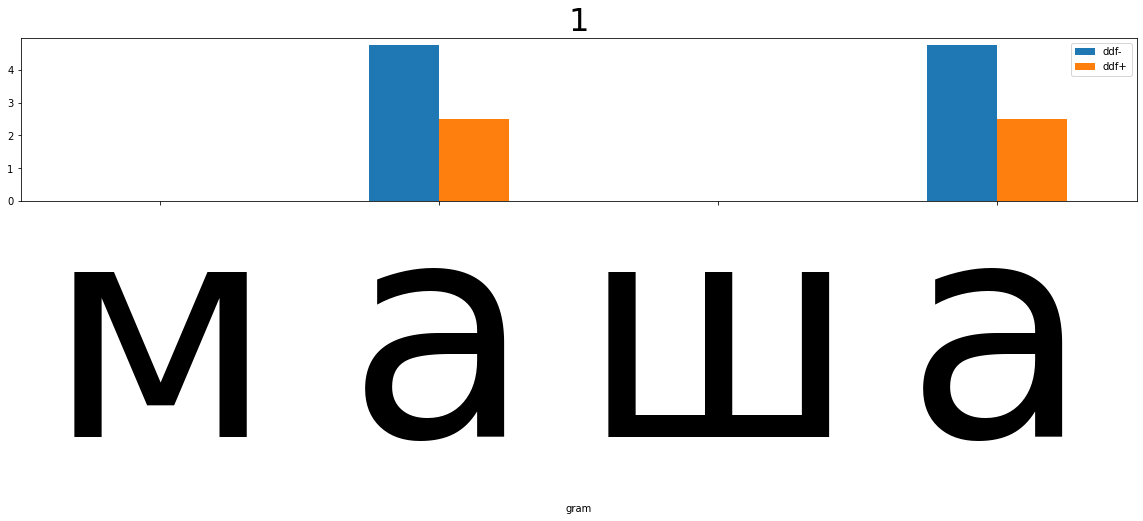

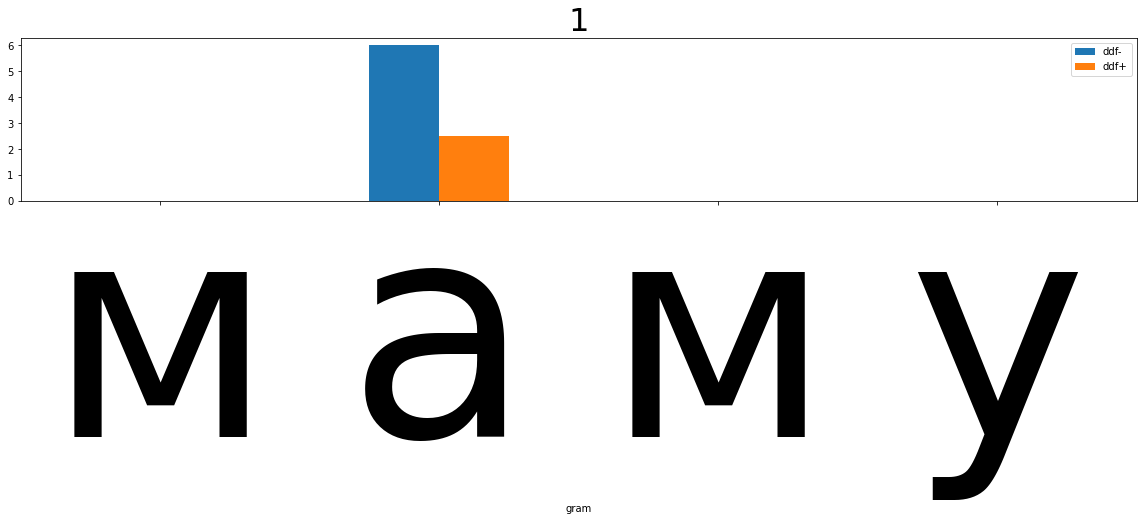

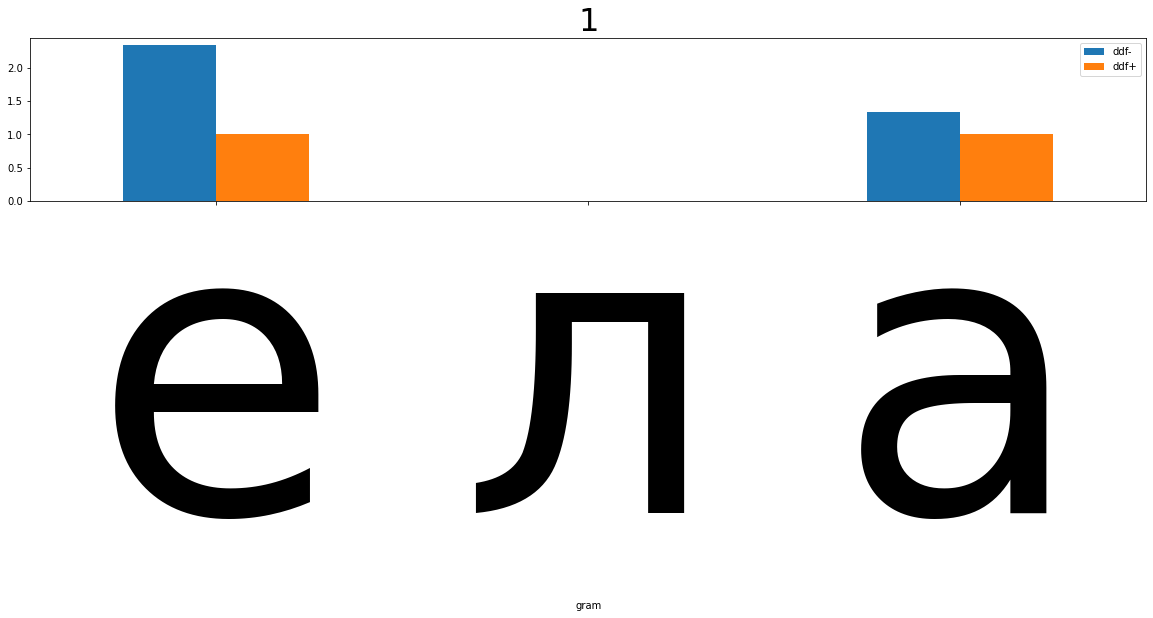

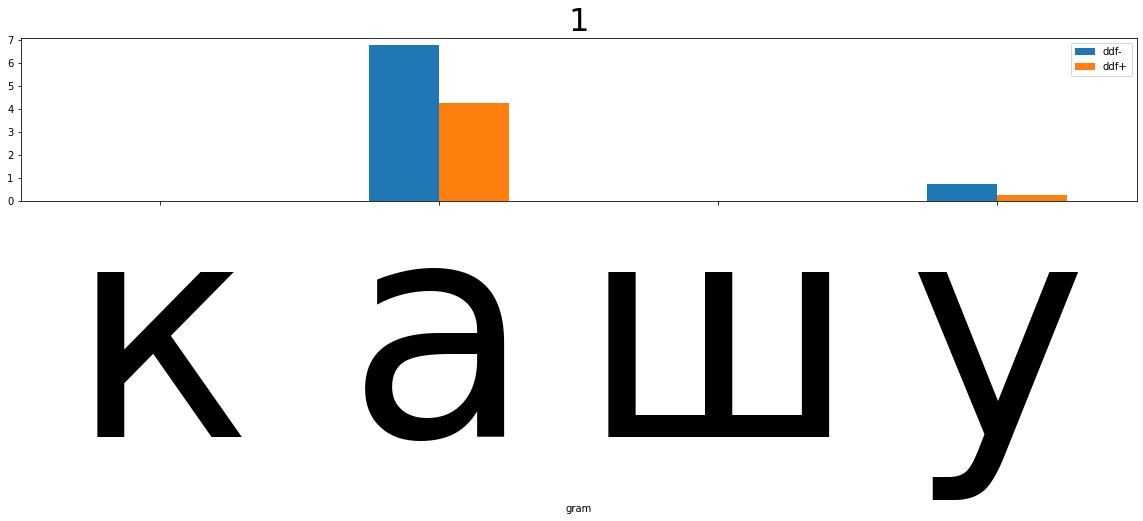

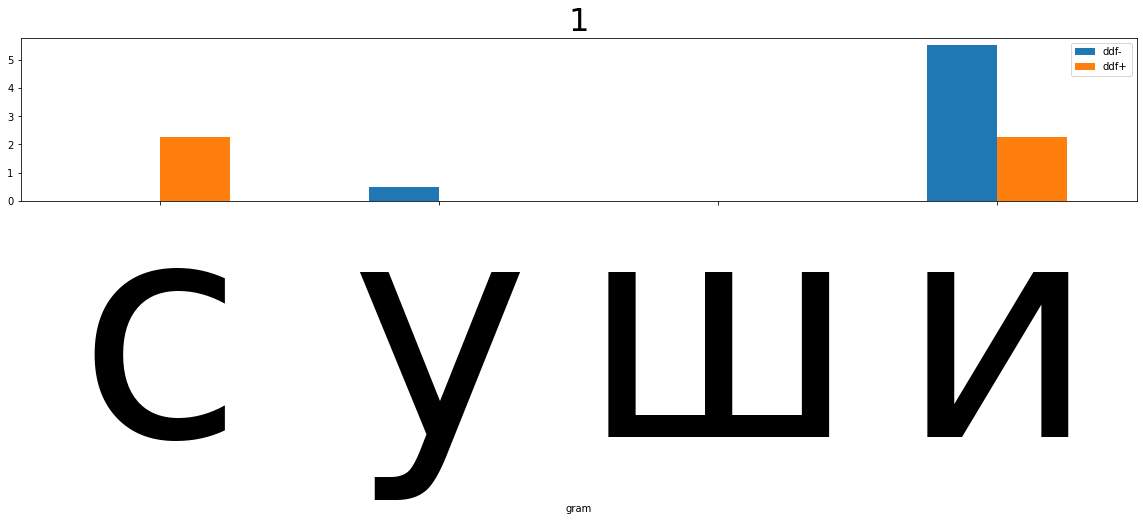

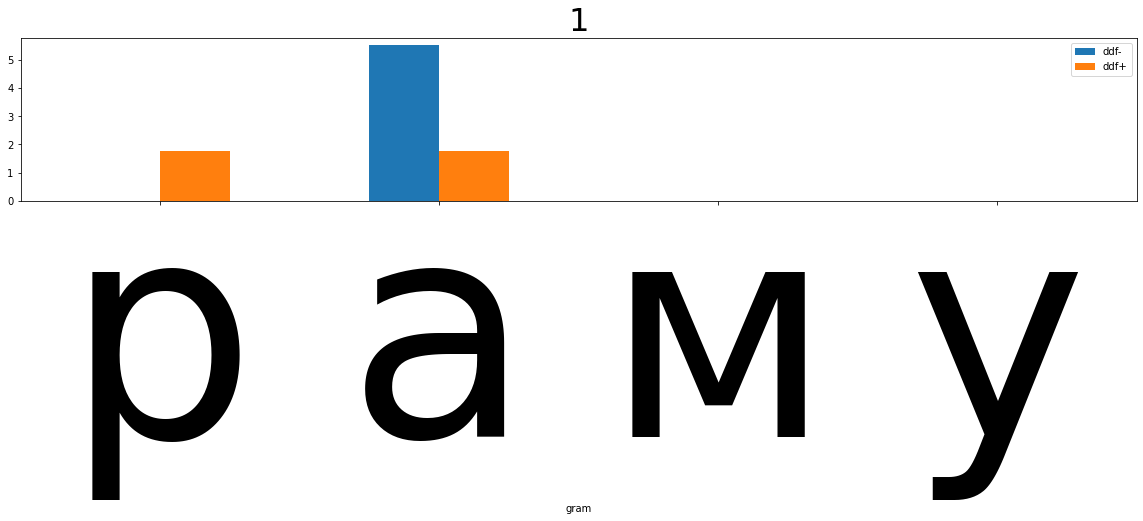

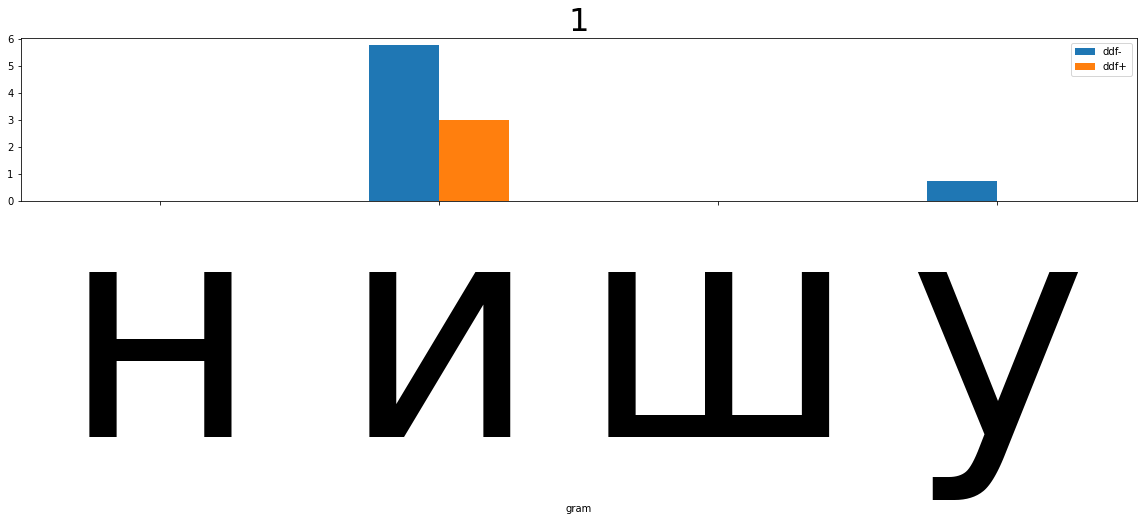

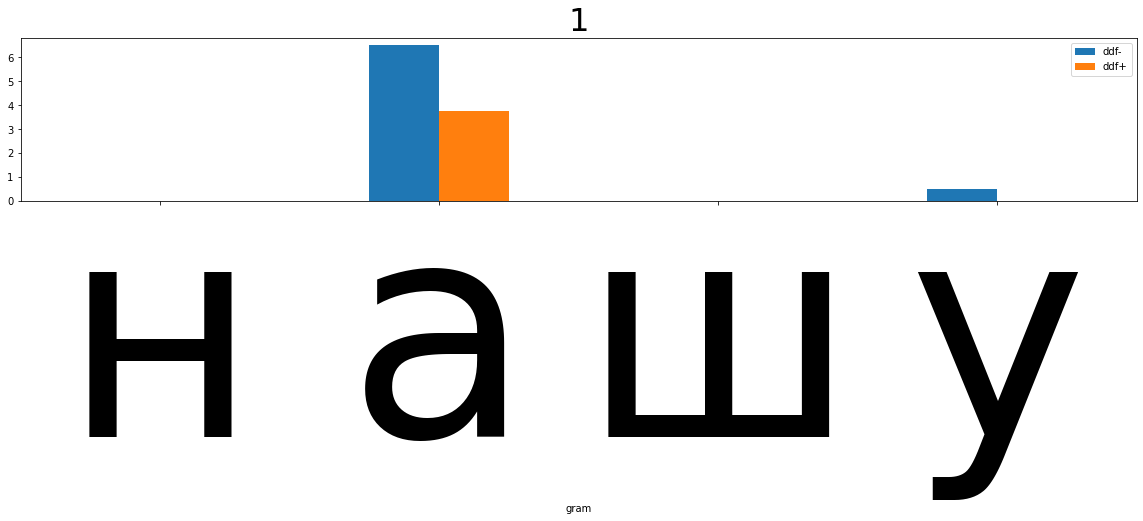

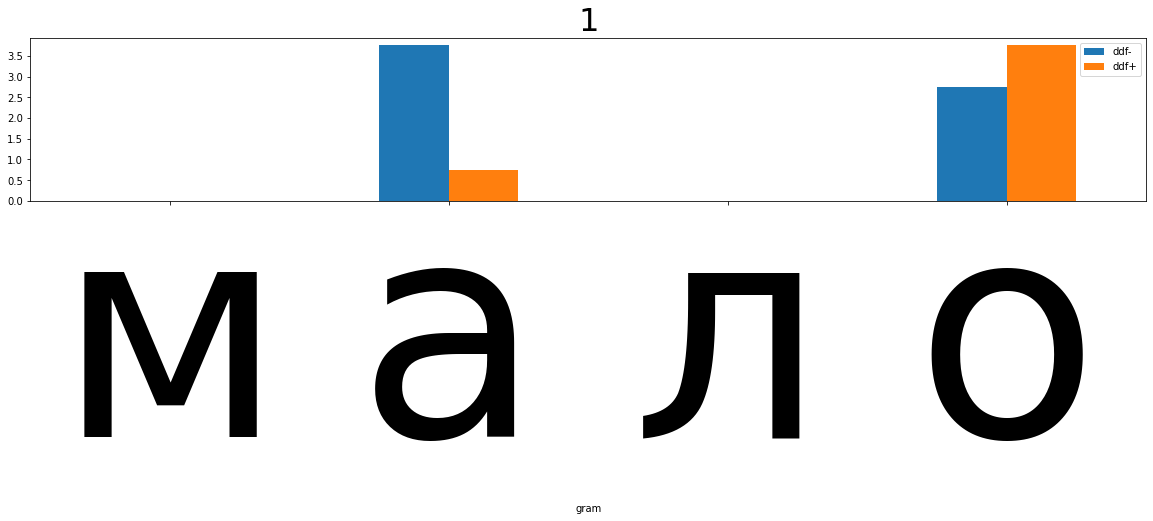

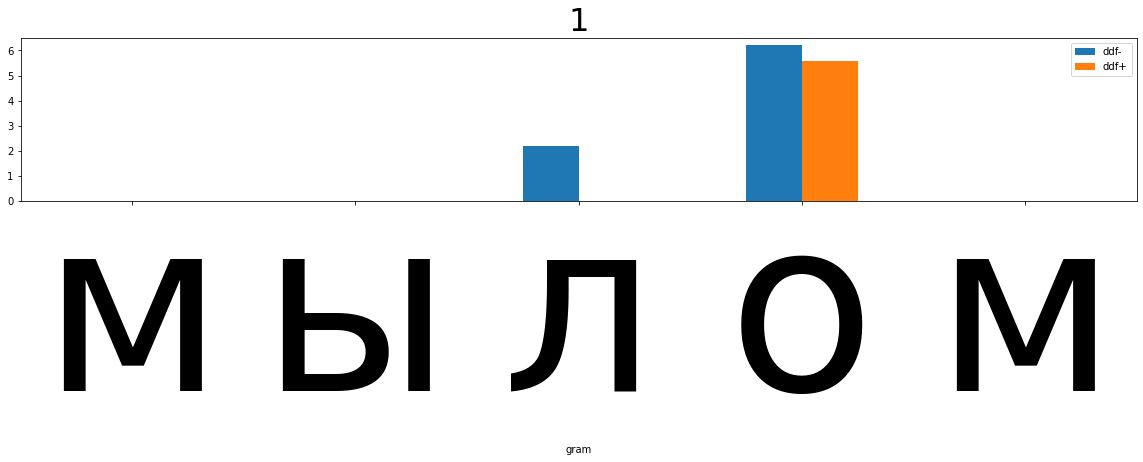

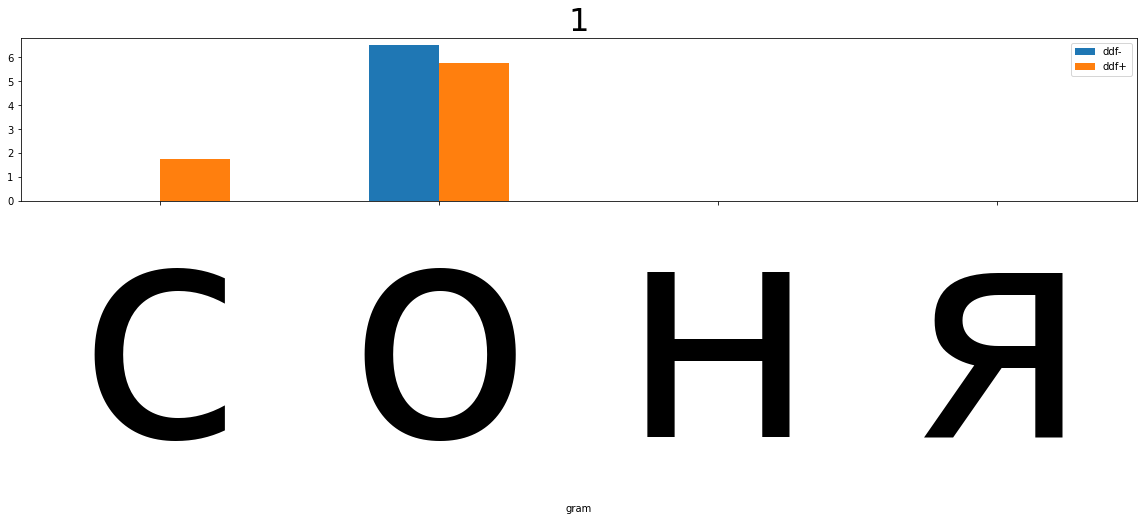

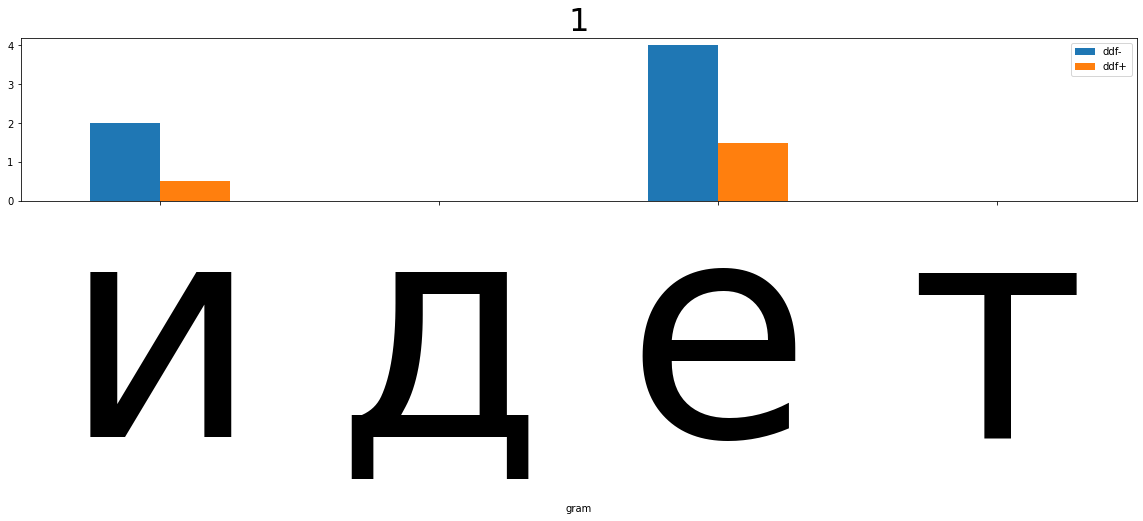

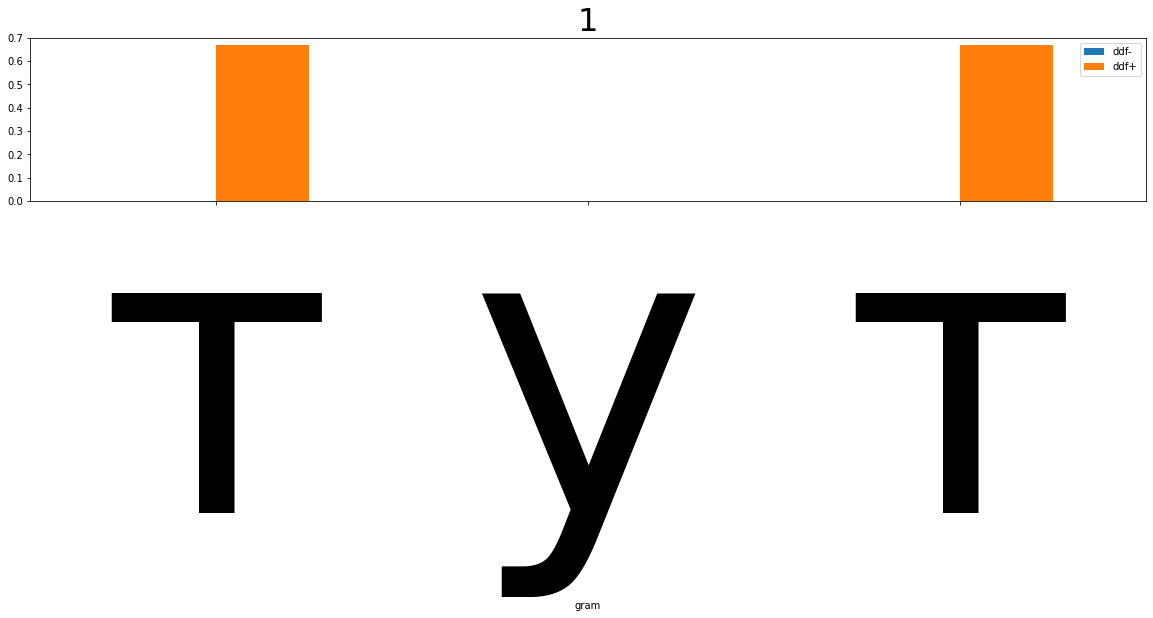

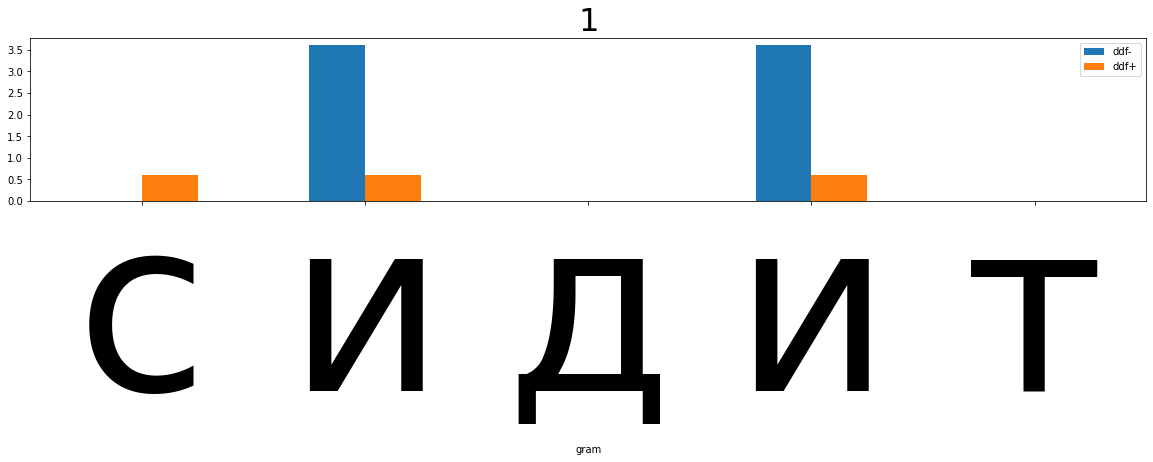

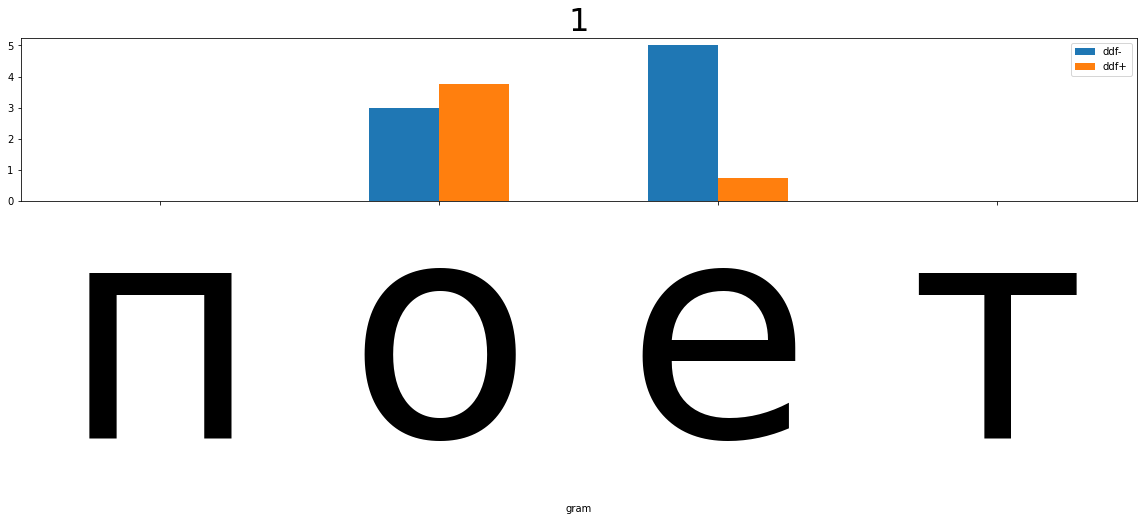

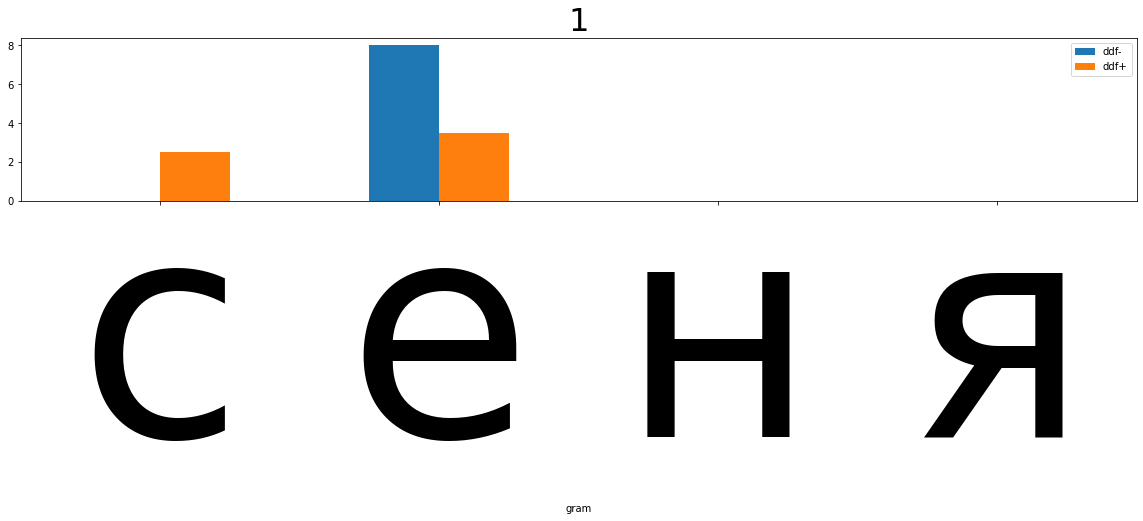

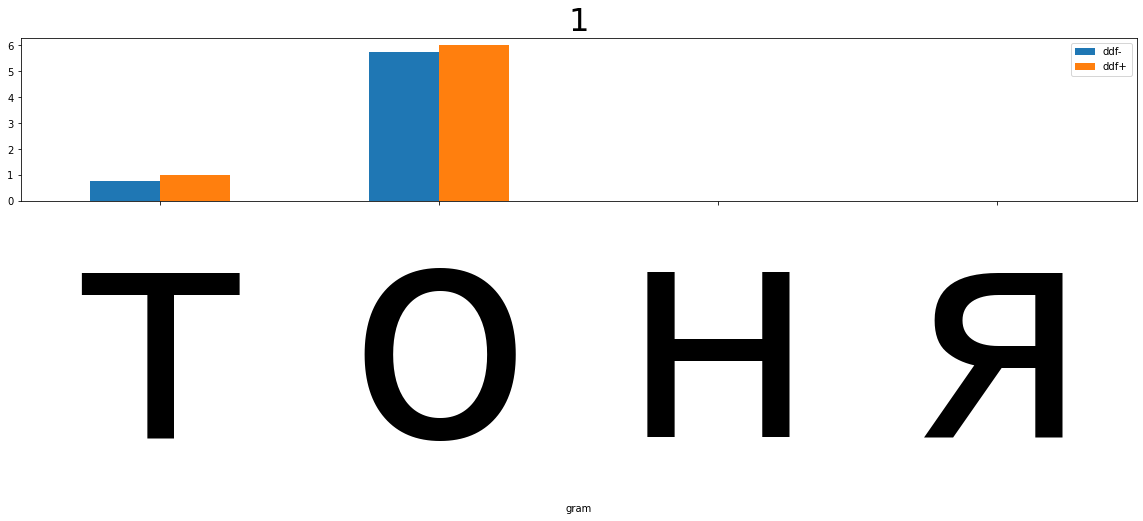

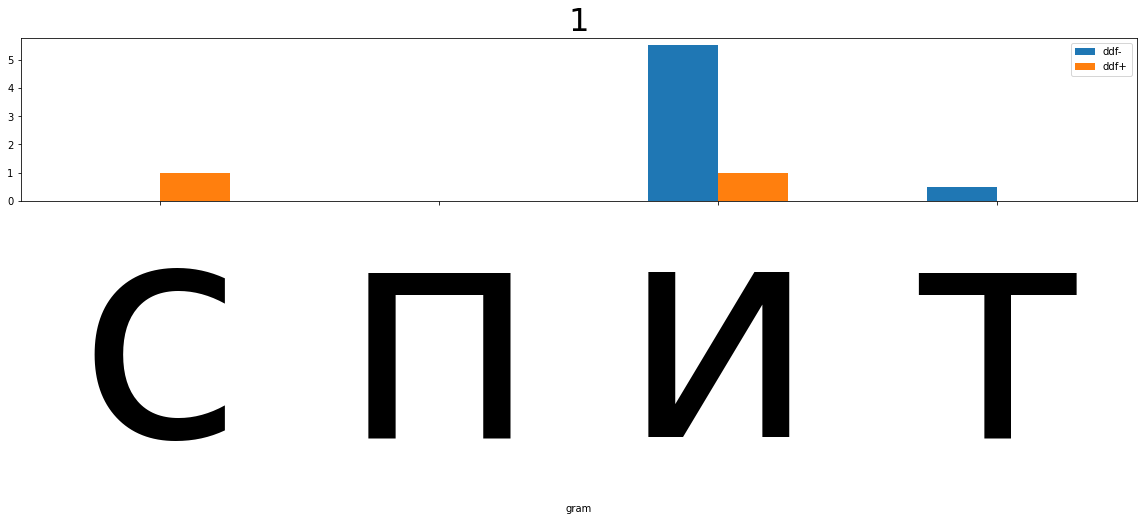

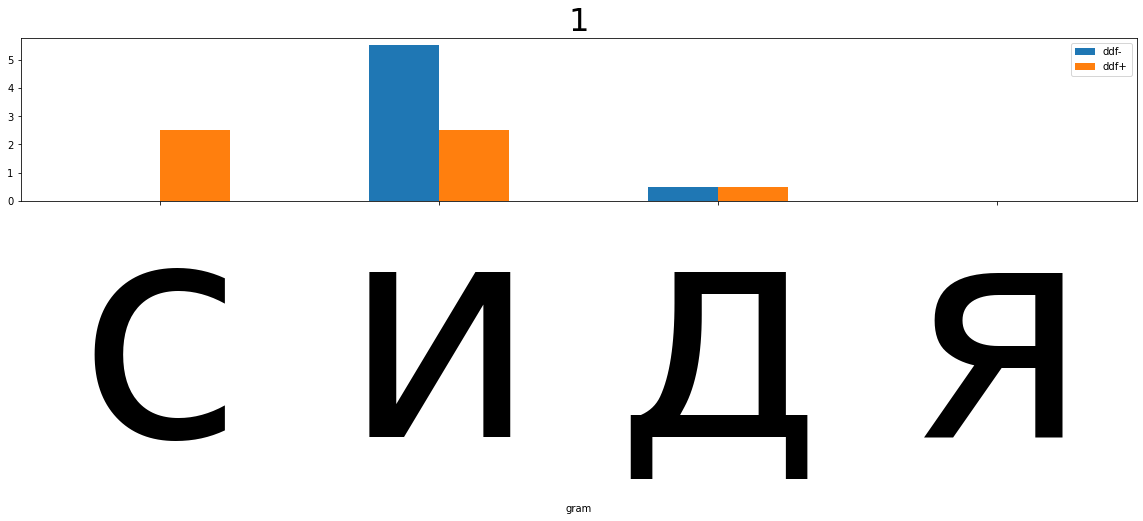

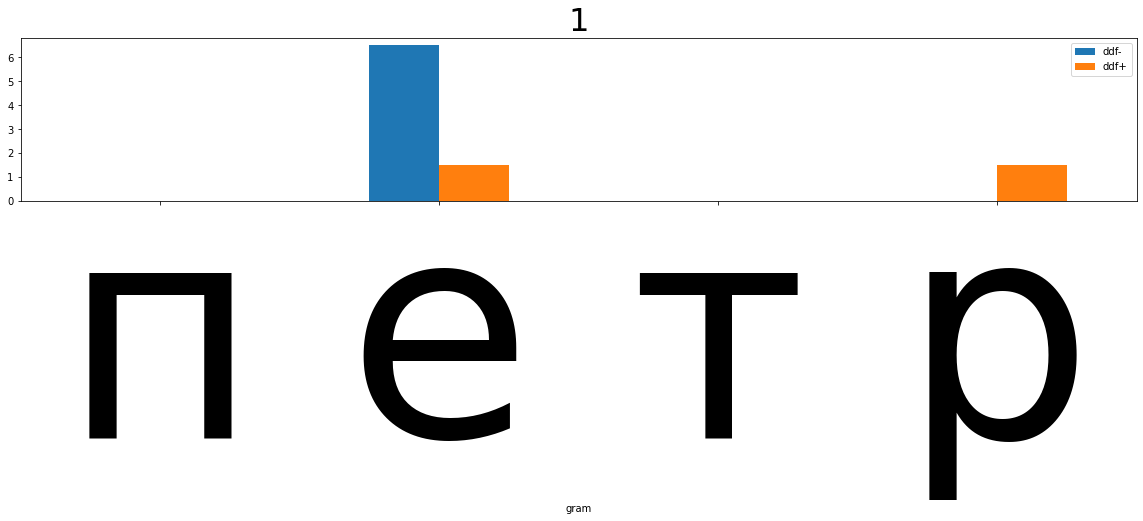

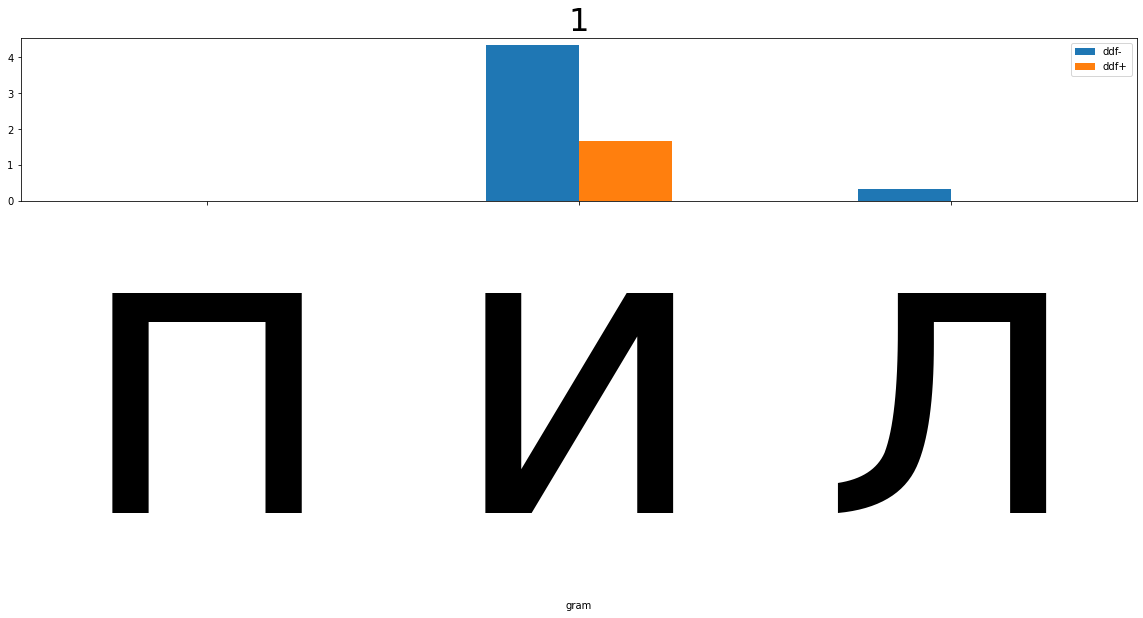

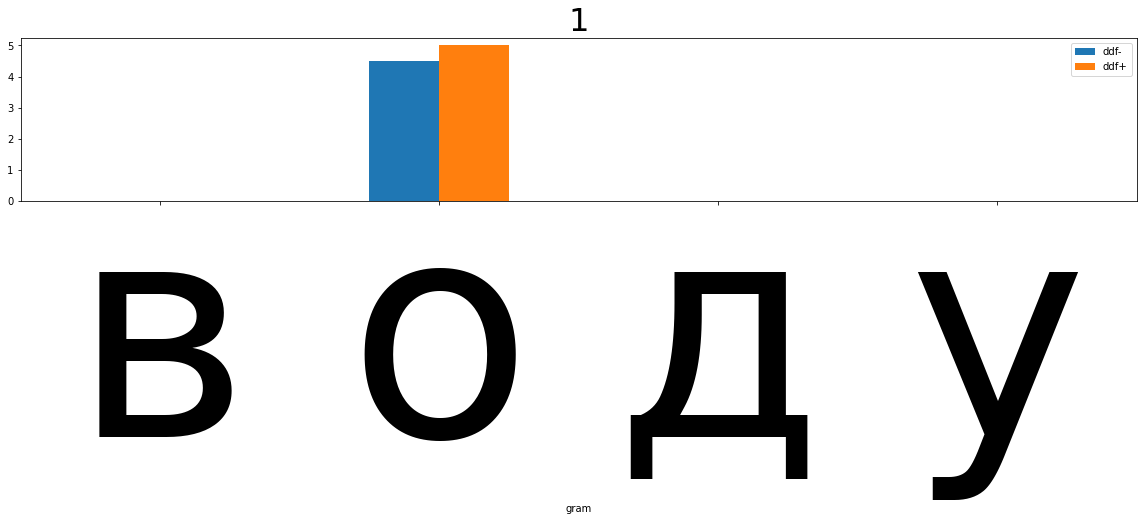

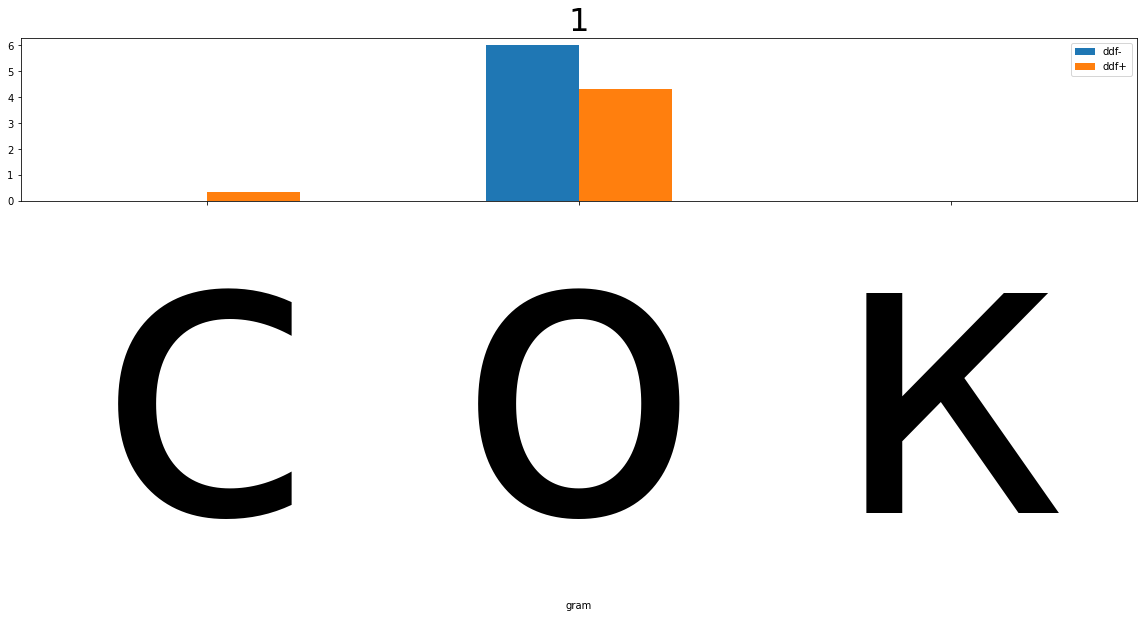

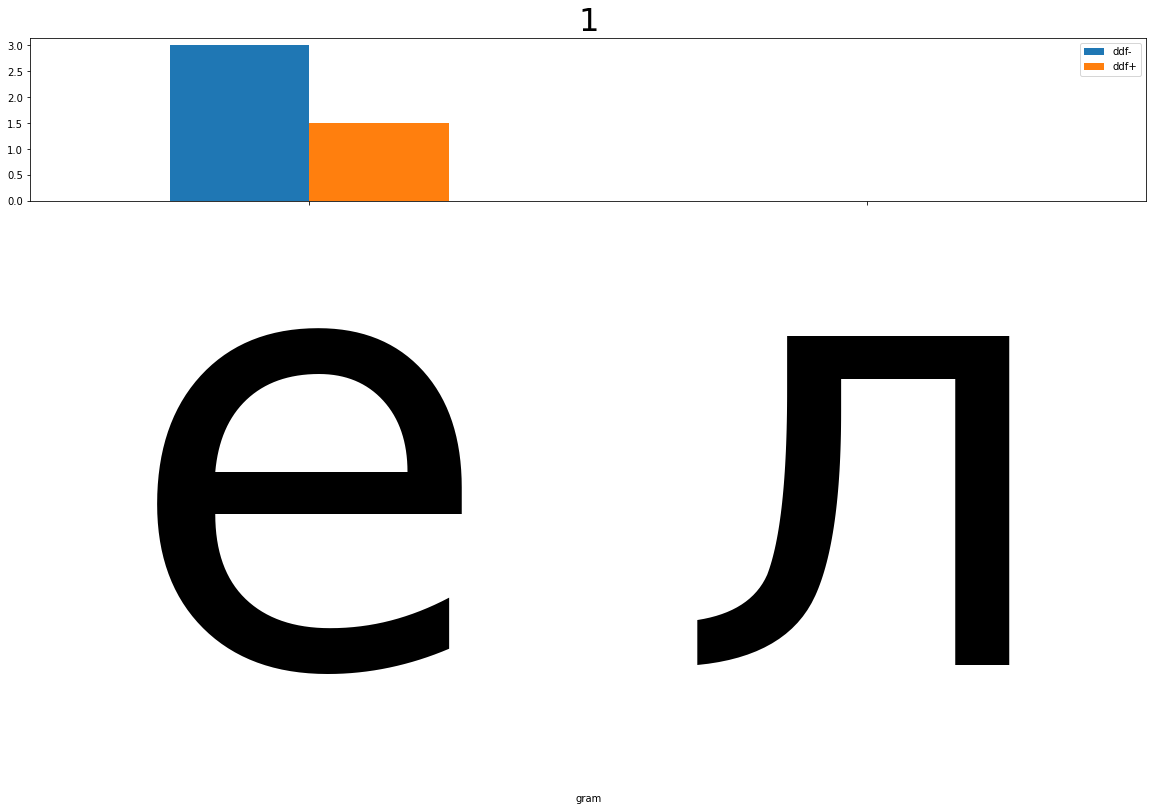

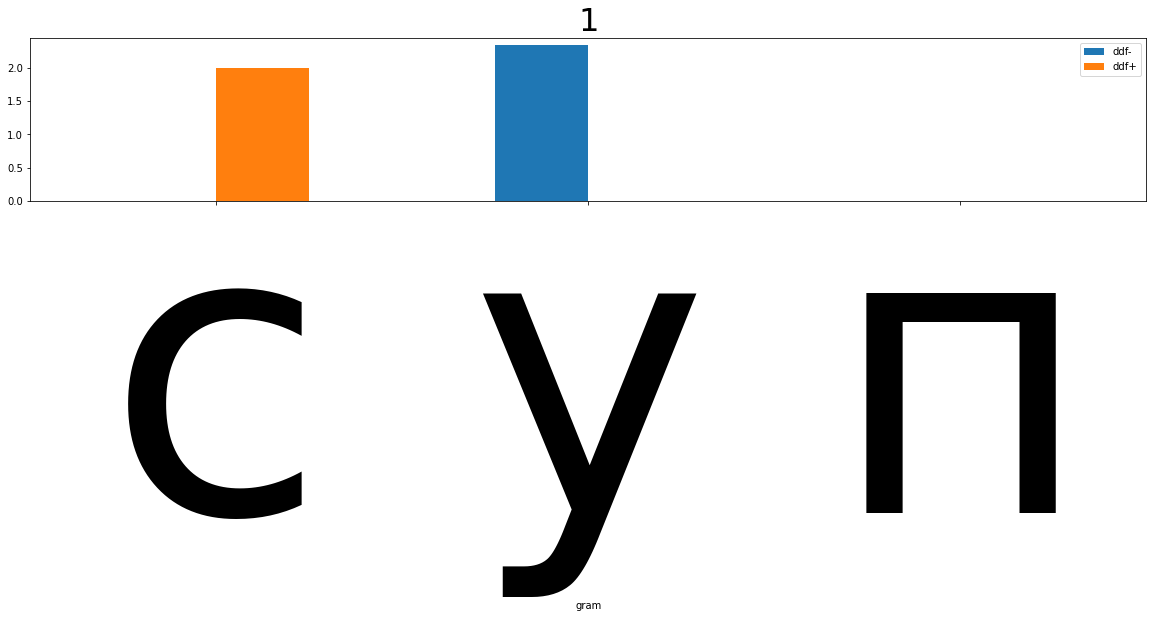

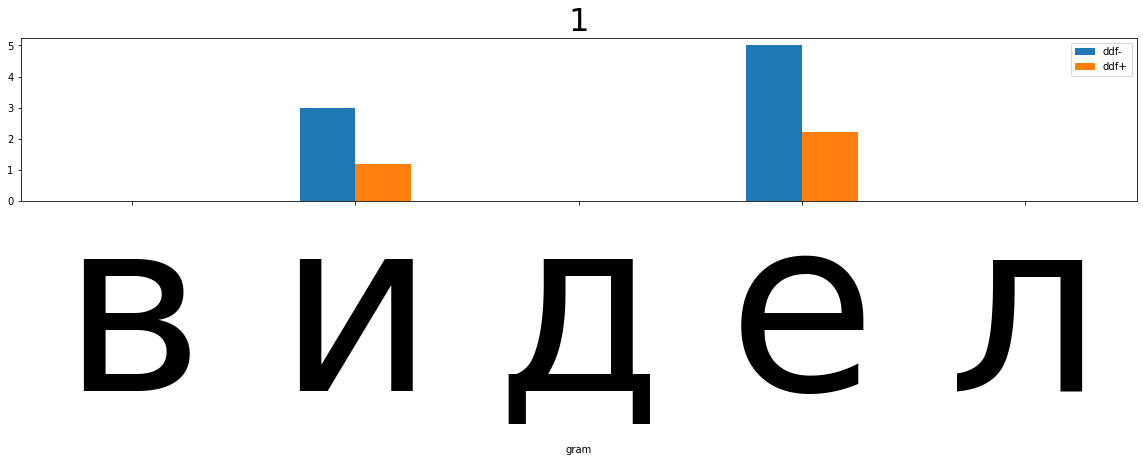

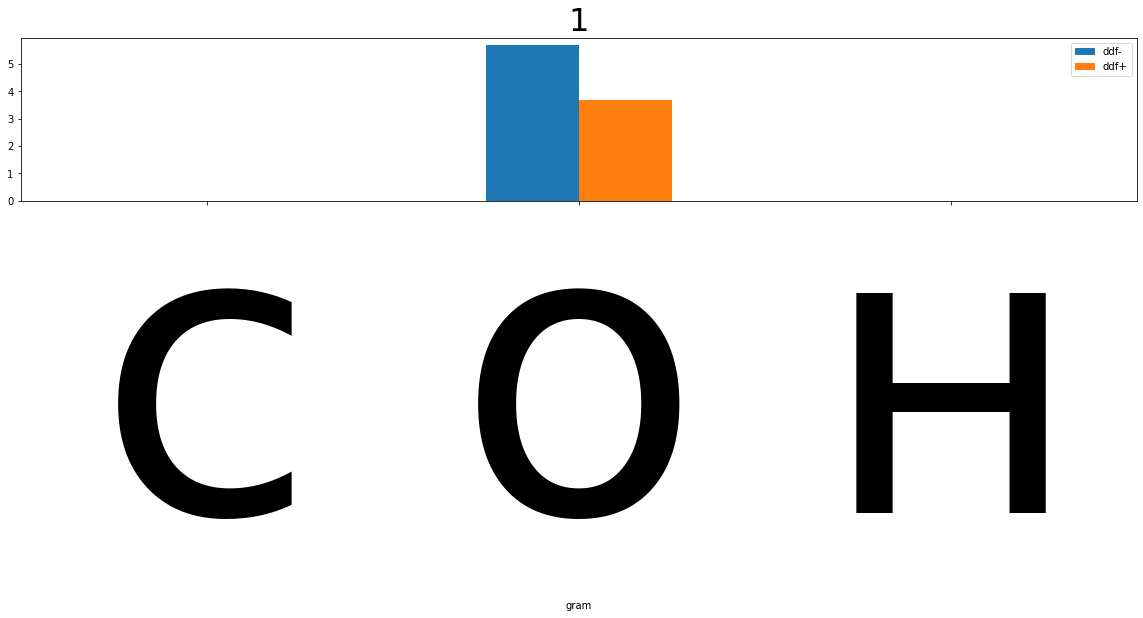

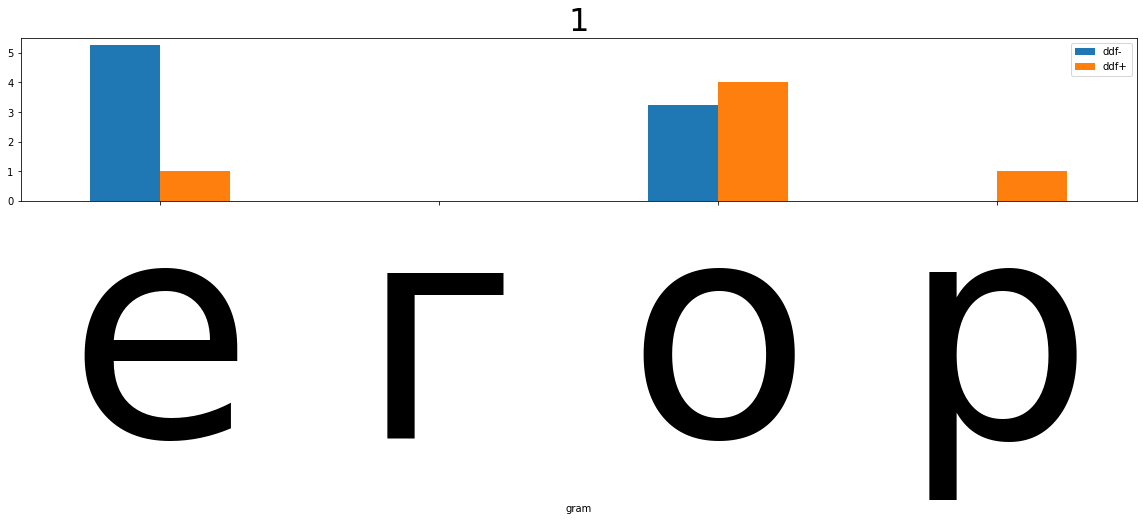

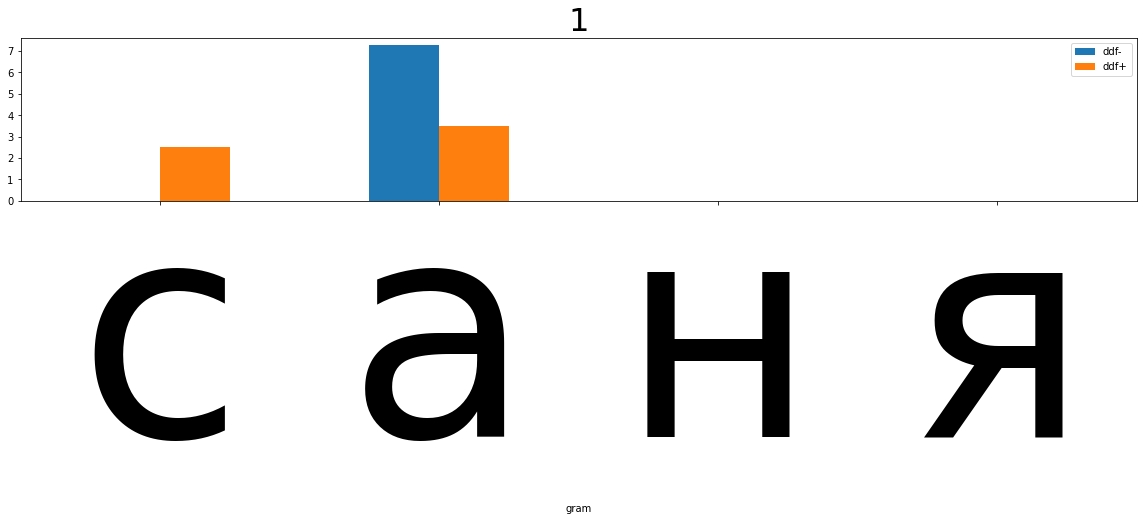

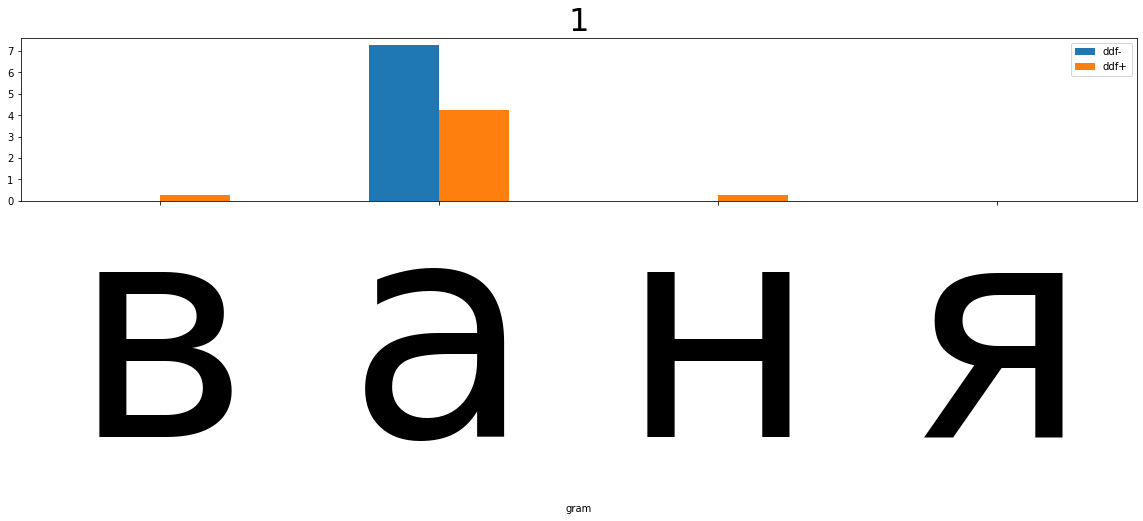

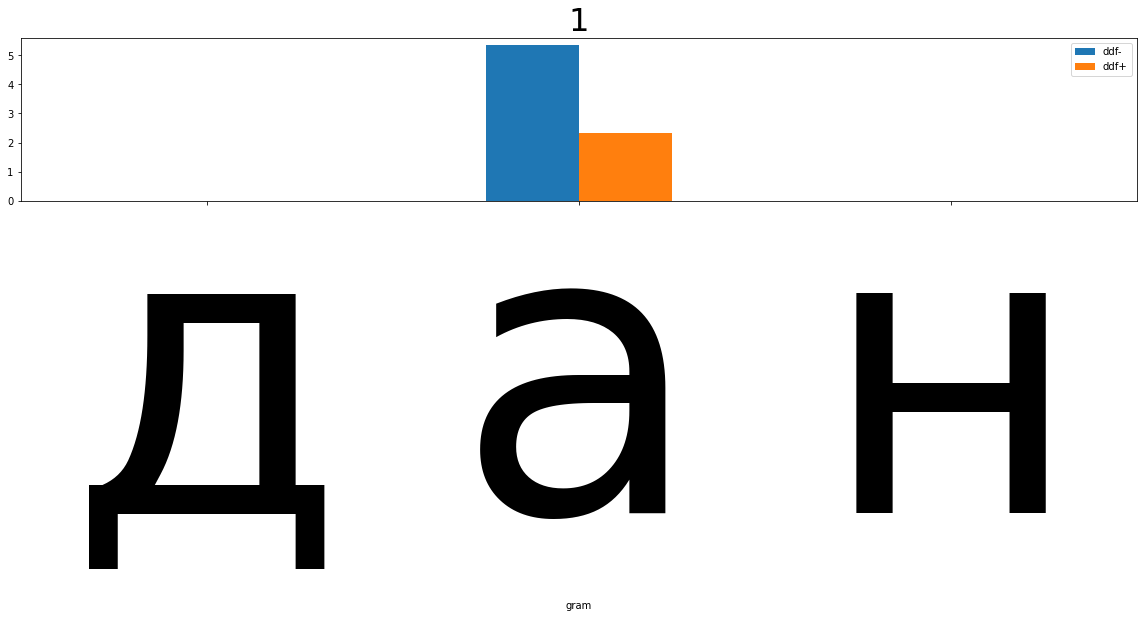

In [26]:
for w in dic:
    df = profile_freedoms_ex_df(mini_ru_base.model,w,1)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(i))
    

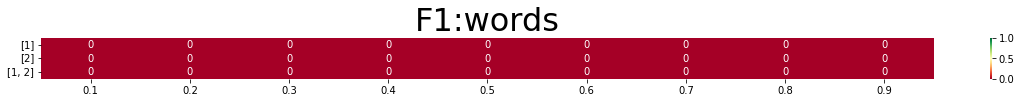

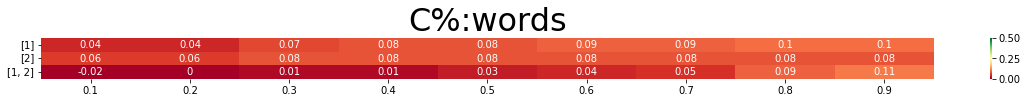

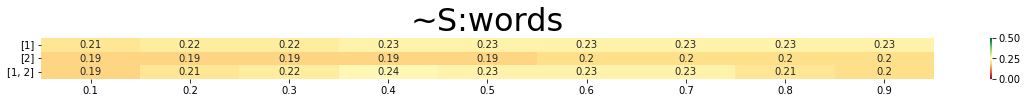

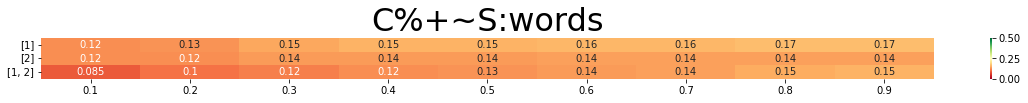

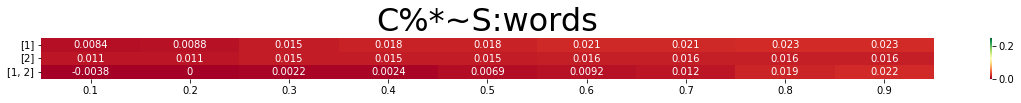

In [27]:
words_ru = [t for t in tokens_ru if len(t) > 1]
metric_list = []
model_threshold = 0
ngram_params = [[1],[2],[1,2]]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
metrics = evaluate_freedom_tokenizer_multimetrics(words_ru,ref_tokenizer,FreedomBasedTokenizer(mini_ru_base,'dvf-','dvf+'),
    ngram_params,token_thresholds,title="words".format(title,model_threshold,parameters),crossmetrics=True)
metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
    
    

In [28]:
tokenizer = FreedomBasedTokenizer(mini_ru_base,'ddf-','ddf+')
tokenizer.set_options(nlist = [1], threshold=0.9)
for w in dic:
    t = tokenizer.tokenize(w)
    print(t)


['м', 'а', 'м', 'а']
['мыл', 'а']
['м', 'а', 'шу']
['м', 'а', 'ш', 'а']
['м', 'а', 'му']
['е', 'ла']
['к', 'а', 'шу']
['с', 'уш', 'и']
['р', 'а', 'му']
['н', 'и', 'шу']
['н', 'а', 'шу']
['м', 'ало']
['мыл', 'о', 'м']
['с', 'о', 'ня']
['ид', 'е', 'т']
['т', 'ут']
['с', 'и', 'д', 'и', 'т']
['по', 'ет']
['с', 'е', 'ня']
['т', 'о', 'ня']
['с', 'п', 'и', 'т']
['с', 'и', 'дя']
['п', 'е', 'тр']
['п', 'и', 'л']
['в', 'о', 'ду']
['с', 'о', 'к']
['е', 'л']
['с', 'уп']
['вид', 'е', 'л']
['с', 'о', 'н']
['его', 'р']
['с', 'а', 'ня']
['в', 'а', 'ня']
['д', 'а', 'н']


### English

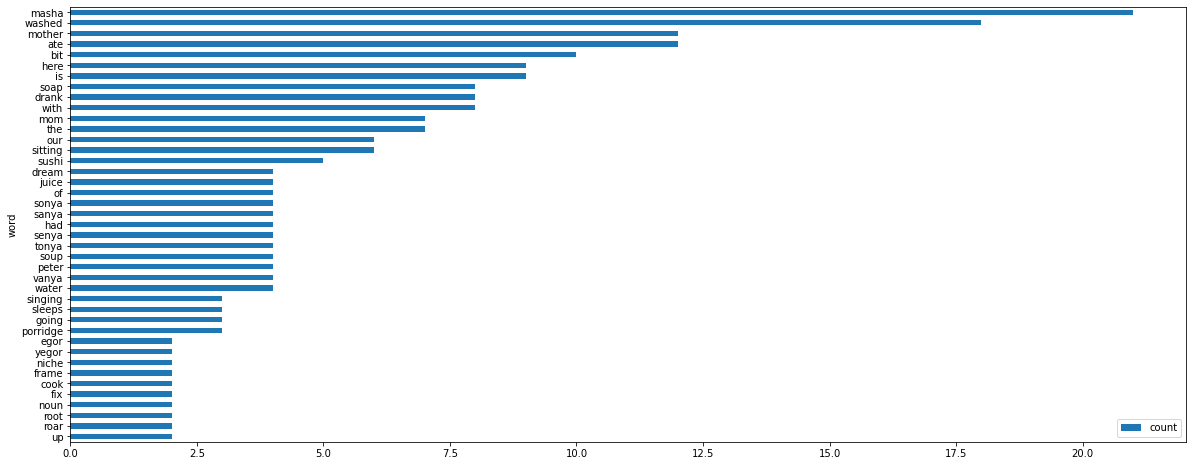

In [29]:
tokenizer_en = FreedomBasedTokenizer(mini_en_base,'ddf-','ddf+')
tokenizer_en.set_options(nlist = [1], threshold=0.7)
tokens_en = tokenizer_en.tokenize(text_en)

word_cnt_en = {}
for t in tokens_en:
    dictcount(word_cnt_en,t)

dic = dict([(key,word_cnt_en[key]) for key in word_cnt_en if len(key) > 1 and word_cnt_en[key] > 1])
plot_dict(dic,'word','count')


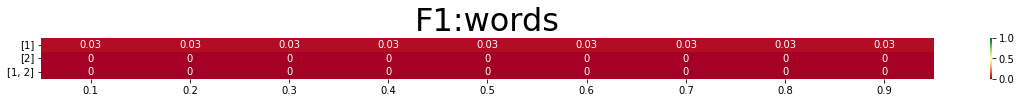

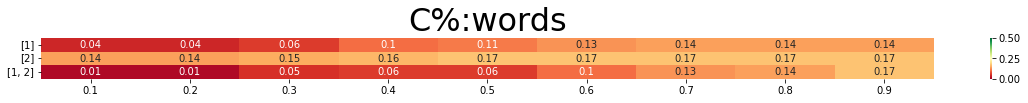

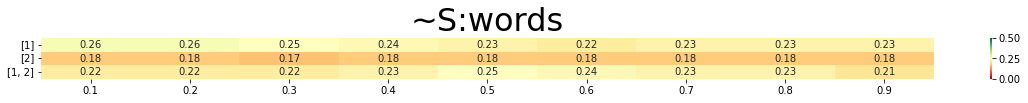

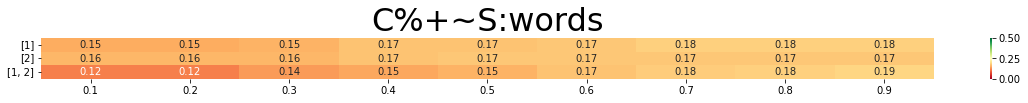

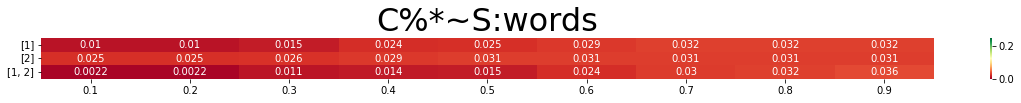

In [30]:
words_en = [t for t in tokens_en if len(t) > 1]
metric_list = []
model_threshold = 0
ngram_params = [[1],[2],[1,2]]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
metrics = evaluate_freedom_tokenizer_multimetrics(words_en,ref_tokenizer,FreedomBasedTokenizer(mini_en_base,'dvf-','dvf+'),
    ngram_params,token_thresholds,title="words".format(title,model_threshold,parameters),crossmetrics=True)
metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])


In [31]:
tokenizer = FreedomBasedTokenizer(mini_en_base,'ddf-','ddf+')
tokenizer.set_options(nlist = [1,2], threshold=0.9)
for w in dic:
    t = tokenizer.tokenize(w)
    print(t)


['m', 'o', 'm']
['wash', 'e', 'd']
['m', 'ash', 'a']
['m', 'o', 'ther']
['a', 't', 'e']
['po', 'rridg', 'e']
['s', 'ush', 'i']
['t', 'h', 'e']
['fram', 'e']
['n', 'ich', 'e']
['o', 'ur']
['b', 'it']
['w', 'it', 'h']
['s', 'oap']
['o', 'f']
['s', 'ony', 'a']
['i', 's']
['g', 'o', 'ing']
['h', 'er', 'e']
['s', 'itt', 'ing']
['s', 'ing', 'ing']
['s', 'eny', 'a']
['to', 'ny', 'a']
['s', 'l', 'e', 'ep', 's']
['p', 'et', 'er']
['d', 'r', 'a', 'nk']
['wat', 'e', 'r']
['juic', 'e']
['e', 'g', 'or']
['s', 'o', 'up']
['y', 'eg', 'o', 'r']
['h', 'a', 'd']
['dr', 'e', 'am']
['s', 'any', 'a']
['va', 'ny', 'a']
['c', 'oo', 'k']
['f', 'i', 'x']
['n', 'o', 'un']
['r', 'o', 'ot']
['r', 'oar']
['u', 'p']
